# >>> The Traveling Salesperson Problem

Consider the [*Traveling Salesperson Problem*](http://en.wikipedia.org/wiki/Traveling_salesman_problem): 

> *Given a set of cities and the distances between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?*

In this notebook we will develop some solutions to the problem, and more generally show *how to think about solving a problem* like this.

<a href="http://www.math.uwaterloo.ca/tsp/history/pictorial/dfj.html"><img src="http://www.math.uwaterloo.ca/tsp/history/img/dantzig.gif"></a>
<br>(An example tour.)
                                     
Understanding What We're Talking About (Vocabulary)
---

Do we understand precisely what the problem is asking? Do we understand all the concepts that the problem talks about?  Do we understand them well enough to implement them in a programming language? Let's take a first pass:

- **A set of cities**: We will need to represent a set of cities; Python's `set` datatype might be appropriate.
- **Distance between each pair of cities**: If `A` and `B` are cities, this could be a function, `distance(A, B),` or a table lookup, `distance[A][B]`.  The resulting distance will be a real number.
- **City**: All we have to know about an individual city is how far it is from other cities. We don't have to know its name, population, best restaurants, or anything else. So a city could be just an integer (0, 1, 2, ...) used as an index into a distance table, or a city could be a pair of (x, y) coordinates, if we are using straight-line distance on a plane.
- **Tour**: A tour is a specified order in which to visit the cities; Python's `list` or `tuple` datatypes would work. For example, given the set of cities `{A, B, C, D}`, a tour might be the list `[B, D, A, C]`, which means to travel from `B` to `D` to `A` to `C` and finally back to `B`.
- **Shortest possible tour**: The shortest tour is the one whose tour length is the minimum of all tours.
- **Tour length**: The sum of the distances between adjacent cities in the tour (including the last city to the first city).   Probably  a function, `tour_length(tour)`.
- **What is ...**: We can define a function to answer the question *what is the shortest possible tour?*  The function takes a set of cities as input and returns a tour as output. I will use the convention that any such function will have a name ending in the letters "`tsp`", the traditional abbreviation for Traveling Salesperson Problem.

At this stage I have a rough sketch of how to attack the problem.  I don't have all the answers, and I haven't committed to specific representations for all the concepts, but I know what all the pieces are, and I don't see anything that stops me from proceeding.

## Python and iPython Notebook: Preliminaries

This document is an [iPython notebook](http://ipython.org/notebook.html): a mix of text and  [Python](http://python.org) code that you can run.   You can learn more from the "Help" button at the top of the page.  But first we'll take care of some preliminaries: the Python statements that import standard libraries that we will be using later on: 

In [1]:
%pylab --no-import-all inline
from __future__ import division
import matplotlib.pyplot as plt
import random
import time
import itertools
import urllib
import csv

Populating the interactive namespace from numpy and matplotlib


# >>> All Tours Algorithm (`alltours_tsp`)

Let's start with an algorithm that is guaranteed to solve the problem (although it is inefficient for large sets of cities). Here is a sketch of the algorithm:

> *<u>All Tours Algorithm</u>: Generate all possible tours of the cities, and choose the shortest tour (the one with minimum tour length).*

In general our design philosophy is to first write an English description of the algorithm, then write Python code that closely mirrors the English description. This will probably require some auxilliary functions and data structures; just assume they exist; put them on a TO DO list, and eventually define them with the same design philosophy.

Here is the start of the implementation:

In [2]:
def alltours_tsp(cities):
    "Generate all possible tours of the cities and choose the shortest tour."
    return shortest_tour(alltours(cities))

def shortest_tour(tours): 
    "Choose the tour with the minimum tour length."
    return min(tours, key=tour_length)

# TO DO: Data types: cities, tours, Functions: alltours, tour_length

**Note**: In Python `min(`*collection*`,key=`*function*`)` means to find the element *x* that is a member of *collection* such that *function(x)* is minimized. So `shortest` finds the tour whose `tour_length` in the minimal among the tours. 

This gives us a good start; the Python code closely matches the English description.  And we know what we need to do next: represent cities and tours, and implement the functions `alltours` and `tour_length`. Let's start with tours.


Representing Tours
------------------

A tour starts in one city, and then visits each of the other cities in order, before returning to the start city.  A natural representation of a tour is a sequence of cities. For example `(1, 2, 3)` could represent a tour that starts in city 1, moves to 2, then 3, and finally returns to 1.  

**Note**: I considered using `(1, 2, 3, 1)` as the representation of this tour. I also considered an ordered list of **edges** between cities: 
`((1, 2), (2, 3), (3, 1))`. In the end, I decided `(1, 2, 3)` was simplest.
    

Now for the `alltours` function.  If a tour is a sequence of cities, then all the tours are *permutations* of the set of all cities. A function to generate all permutations of a set is already provided in Python's standard `itertools` library module; we can use it as our implementation of `alltours`:

In [3]:
alltours = itertools.permutations 

For *n* cities there are *n*! (that is, the factorial of *n*) permutations.
Here's are all 3! = 6 tours of 3 cities:

In [4]:
cities = {1, 2, 3}

list(alltours(cities))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

The length of a tour is the sum of the lengths of each edge in the tour; in other words, the sum of the distances between consecutive cities in the tour, including the distance form the last city back to the first:

In [5]:
def tour_length(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

# TO DO: Functions: distance, Data types: cities

**Note**: I use one Python-specific trick: when `i` is 0, then `distance(tour[0], tour[-1])` gives us the wrap-around distance between the first and last cities, because `tour[-1]` is the last element of `tour`. 

Representing Cities
--------------------------------

We determined that the only thing that matters about cities is the distance between them. But before we can decide about how to represent cities, and before we can define `distance(A, B)`,  we have to make a choice. In the fully general version of the TSP, the "distance" between two cities could be anything: it could factor in the amount of time it takes to travel between cities, the twistiness of the road, or anything else. The `distance(A, B)` might be different from `distance(B, A)`. So the distances could be represented by a matrix `distance[A][B]`, where any entry in the matrix could be any (non-negative) numeric value.
    
But we will ignore the fully general TSP and concentrate on an important special case, the **Euclidean TSP**, where the distance between any two cities is the [Euclidean distance](http://en.wikipedia.org/wiki/Euclidean_distance), the straight-line distance between points in a two-dimensional plane. So a city can be represented by a two-dimensional point: a pair of *x* and *y* coordinates. We will use the constructor function `City`, so that `City(300, 0)` creates a city with x-coordinate of 300 and y coordinate of 0.  Then `distance(A, B)` will be a function that uses the *x* and *y* coordinates to compute the distance between `A` and `B`.

Representing Points and Computing `distance`
---
        
OK, so a city can be represented as just a two-dimensional point. But how will we represent points?  Here are some choices, with their pros and cons:

* **tuple:** A point is a two-tuple of (*x*, *y*) coordinates, for example, `(300, 0)`. **Pro:** Very simple. 
**Con:** doesn't distinguish Points from other two-tuples.  
            
* **class:** Define a custom `Point` class with *x* and *y* slots. **Pro:** explicit, gives us `p.x` and `p.y` accessors.  **Con:** less efficient.
            
* **complex:** Python already has the two-dimensional point as a built-in numeric data type, but in a non-obvious way: as `complex` numbers, which inhabit the two-dimensional (real &times; imaginary) plane.  **Pro:** efficient. **Con:** a little confusing; doesn't distinguish Points from other complex numbers.


Any of these choices would work perfectly well; I decided to use complex numbers and to implement the functions `X` and `Y` to make things less confusing. An advantage of `complex` numbers is that computing the distance between two points is easy&mdash;the absoute value of their difference:

In [6]:
# Cities are represented as Points, which are represented as complex numbers
Point = complex
City  = Point

def X(point): 
    "The x coordinate of a point."
    return point.real

def Y(point): 
    "The y coordinate of a point."
    return point.imag

def distance(A, B): 
    "The distance between two points."
    return abs(A - B)

Here's an example of computing the distance between two cities:

In [7]:
A = City(3, 0)
B = City(0, 4)
distance(A, B)

5.0

Random Sets of Cities
---

The input to a TSP algorithm should be a set of cities. I can make a random set of *n* cities by calling `City` *n* times, each with different random *x* and *y* coordinates:

In [8]:
{City(random.randrange(1000), random.randrange(1000)) for c in range(6)}

{(288+9j), (668+743j), (817+11j), (669+414j), (810+496j), (659+568j)}

The function `Cities` does that (and a bit more):

In [9]:
def Cities(n, width=900, height=600, seed=42):
    "Make a set of n cities, each with random coordinates within a (width x height) rectangle."
    random.seed(seed * n)
    return frozenset(City(random.randrange(width), random.randrange(height))
                     for c in range(n))

There are three complications that I decided to tackle in `Cities`:

**Complication 1:** IPython's matplotlib plots (by default) in a rectangle that is 1.5 times wider than it is high; that's why I specified a width of 900 and a height of 600. If you want the coordinates of your cities to be bounded by a different size rectangle, you can change width or height.

**Complication 2:** Sometimes I want `Cities(n)` to be a true function, returning the same result each time. This is very helpful for getting repeatable results: if I run a test twice, I get the same results twice. 
But other times I would like to be able to do an experiment, where, for example, I call `Cities(n)` 30 times and get 30 different sets, and I then compute the average tour length produced by my algorithm across these 30 sets. Can I get both behaviors out of one function? *Yes!*  The trick is the additional optional parameter, `seed`.  Two calls to `Cities` with the same `n` and `seed` parameters will always return the same set of cities, and two calls with different values for `seed` will return different sets. This is implemented by calling the function `random.seed`, which resets the random number generator.

**Complication 3:** Once I create a set of Cities, I don't want anyone messing with my set. For example, I don't want an algorithm that claims to "solve" a problem by deleting half the cities from the input set, then finding a tour of the remaining cities.  Therefore, I make `Cities` return a `frozenset` rather than a `set`.  A `frozenset` is *immutable*; nobody can change it once it is created.

For example:

In [10]:
# A set of 5 cities
Cities(5)

frozenset({(151+11j), (346+408j), (261+23j), (122+324j), (654+243j)})

In [11]:
# The same set of 5 cities each time
[Cities(5) for i in range(3)]

[frozenset({(151+11j), (346+408j), (261+23j), (122+324j), (654+243j)}),
 frozenset({(151+11j), (346+408j), (261+23j), (122+324j), (654+243j)}),
 frozenset({(151+11j), (346+408j), (261+23j), (122+324j), (654+243j)})]

In [12]:
# A different set of 5 cities each time
[Cities(5, seed=i) for i in range(3)]

[frozenset({(705+181j), (759+454j), (460+242j), (378+155j), (428+350j)}),
 frozenset({(849+389j), (715+565j), (26+279j), (665+553j), (560+445j)}),
 frozenset({(468+196j), (520+123j), (588+96j), (514+257j), (731+494j)})]

Now we are ready to apply the `alltours_tsp` function to find the shortest tour:

In [13]:
alltours_tsp(Cities(8))

((648+296j),
 (779+522j),
 (329+588j),
 (308+456j),
 (5+449j),
 (77+259j),
 (715+107j),
 (823+86j))

In [14]:
tour_length(alltours_tsp(Cities(8)))

2395.20003959213

Quick, is that the right answer?  I have no idea, and you probably can't tell either. But if we could *plot* the tour we'd understand it better and might be able to see at a glance if the tour is optimal.

Plotting Tours
---

I define `plot_tour(tour)` to plot the cities (as circles) and the tour (as lines):

In [15]:
def plot_tour(tour): 
    "Plot the cities as circles and the tour as lines between them."
    plot_lines(list(tour) + [tour[0]])
    
def plot_lines(points, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot(map(X, points), map(Y, points), style)
    plt.axis('scaled'); plt.axis('off')

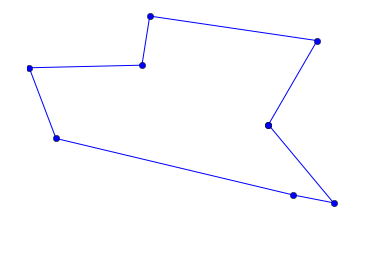

In [16]:
plot_tour(alltours_tsp(Cities(8)))

That looks much better!  To me, it looks like the shortest possible tour, although I don't have an easy way to prove it. Let's go one step further and define a function, `plot_tsp(algorithm, cities)` that will take a TSP algorithm (such as `alltours_tsp`) and a set of cities,  apply the algorithm to the cities to get a tour, check that the tour is reasonable, plot the tour,  and print information about the length of the tour and the time it took to find it:

In [17]:
def plot_tsp(algorithm, cities):
    "Apply a TSP algorithm to cities, plot the resulting tour, and print information."
    # Find the solution and time how long it takes
    t0 = time.clock()
    tour = algorithm(cities)
    t1 = time.clock()
    assert valid_tour(tour, cities)
    plot_tour(tour); plt.show()
    print("{} city tour with length {:.1f} in {:.3f} secs for {}"
          .format(len(tour), tour_length(tour), t1 - t0, algorithm.__name__))
    
def valid_tour(tour, cities):
    "Is tour a valid tour for these cities?"
    return set(tour) == set(cities) and len(tour) == len(cities)

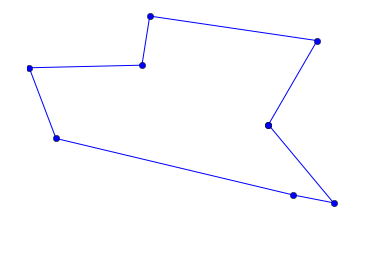

8 city tour with length 2395.2 in 0.195 secs for alltours_tsp


In [18]:
plot_tsp(alltours_tsp, Cities(8))

## All Non-Redundant Tours Algorithm (improved `alltours_tsp`)

We said there are *n*! tours of *n* cities, and thus 6 tours of 3 cities:

In [19]:
list(alltours({1, 2, 3}))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

But this is redundant: `(1, 2, 3)`, `(2, 3, 1)`, and `(3, 1, 2)` are three ways of describing the same tour. So let's arbitrarily say that all tours must start with the first city in the set of cities. We'll just pull the first city out, and then tack it back on to all the permutations of the rest of the cities.  

While we're re-assembling a tour from the start city and the rest, we'll take the opportunity to construct the tour as a *list* rather than a *tuple*. It doesn't matter much now, but later on we will want to represent *partial* tours, to which we will want to append cities one by one; appending can only be done to lists, not tuples.

In [20]:
def alltours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + Tour(rest)
            for rest in itertools.permutations(cities - {start})]

def first(collection):
    "Start iterating over collection, and return the first element."
    return next(iter(collection))

Tour = list  # Tours are implemented as lists of cities

We can verify that for 3 cities there are now only 2 tours (not 6) and for 4 cities there are 6 tours (not 24):

In [21]:
alltours({1, 2, 3})

[[1, 2, 3], [1, 3, 2]]

In [22]:
alltours({1, 2, 3, 4})

[[1, 2, 3, 4],
 [1, 2, 4, 3],
 [1, 3, 2, 4],
 [1, 3, 4, 2],
 [1, 4, 2, 3],
 [1, 4, 3, 2]]

**Note:** We could say that there is only one tour of three cities, because `[1, 2, 3]` and `[1, 3, 2]` are in some sense the same tour, one going clockwise and the other counterclockwise.  However, I choose not to do that, for two reasons.  First, it would mean we can never handle maps where the distance from A to B is different from B to A. Second, it would complicate the code (if only by a line or two) while not saving much run time.

We can  verify that calling `alltours_tsp(Cities(8))` still works and gives the same tour with the same total distance. But it now runs faster:

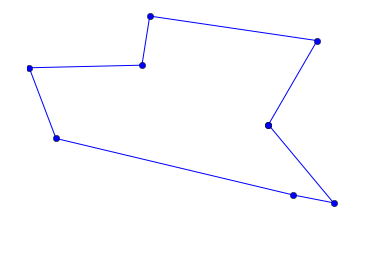

8 city tour with length 2395.2 in 0.051 secs for alltours_tsp


In [23]:
plot_tsp(alltours_tsp, Cities(8))

Now let's try a much harder 10-city tour:

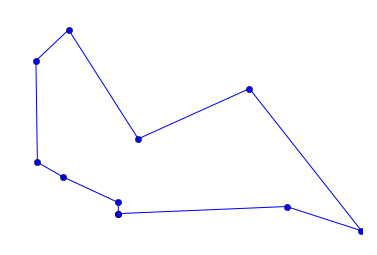

10 city tour with length 2492.2 in 1.534 secs for alltours_tsp


In [24]:
plot_tsp(alltours_tsp, Cities(10))

Complexity of `alltours_tsp`
---

It takes about 2 seconds on my machine to solve this 10-city problem. In general, the function `TSP` looks at (*n*-1)! tours for an *n*-city problem, and each tour has *n* cities, so the total time required for *n* cities should be roughly proportional to *n*!. This means that the time grows rapidly with the number of cities.  *Really* rapidly. This table shows the actual time for solving a 10 city problem, and the exepcted time for solving larger problems:

<table>
<tr><th>n <th>expected time for `alltours_tsp(Cities(n))`
<tr><td>10<td>Covering 10! tours = 2 secs
<tr><td>11<td>2 secs &times; 11! / 10! &approx; 22 secs
<tr><td>12<td>2 secs &times; 12! / 10! &approx; 4 mins
<tr><td>14<td>2 secs &times; 14! / 10! &approx; 13 hours
<tr><td>16<td>2 secs &times; 16! / 10! &approx; 200 days
<tr><td>18<td>2 secs &times; 18! / 10! &approx; 112 years
<tr><td>25<td>2 secs &times; 25! / 10! &approx; <a href="https://www.google.com/search?q=2+seconds*25!+%2F+10!+in+years">270 billion years</a>
</table>

There must be a better way ...

# Approximate Algorithms

What if we are willing to settle for a tour that is short, but not guaranteed to be shortest? Then we can save billions of years of compute time: we will show several *approximate* algorithms, which find tours that are typically within 10% of the shortest possible tour, and can handle thousands of cities in a few seconds. (**Note:** There are more sophisticated approximate algorithms that can handle hundreds of thousands of cities and come within 0.01% or better of the shortest possible tour.)

So how do we come up with an approximate algorithm?   Here are two general plans of how to create a tour:

* **Nearest Neighbor Algorithm**: Make the tour go from a city to its nearest neighbor. Repeat.
* **Greedy Algorithm**: Find the shortest distance between any two cities and include that edge in the tour. Repeat.

We will expand these ideas into full algorithms.

In addition, here are four very general strategies that apply not just to TSP, but to any optimization problem. An **optimization problem** is one in which the goal is to find a solution that is best (or near-best) according to some metric,
out of a pool of many candidate solutions. The strategies are:

* **Repetition Strategy**: Take some algorithm and re-run it multiple times, varying some aspect each time, and take the solution with the best score.
* **Alteration Strategy**: Use some algorithm to create a solution, then make small changes to the solution to improve it.
* **Ensemble Strategy**: Take two or more algorithms, apply all of them to the problem, and pick the best solution.

And here are two more strategies that work for a wide variety of problems:

* **Divide and Conquer**: Split the input in half, solve the problem for each half, and then combine the two partial solutions.

* **Stand on the Shoulders of Giants** *or* **Just Google It**: Find out what others have done in the past, and either copy it or build on it.

# >>> Nearest Neighbor Algorithm (`nn_tsp`)

Here is a description of the nearest neighbor algorithm:

> *Nearest Neighbor Algorithm: Start at any city; at each step extend the tour by moving from the previous city to its nearest neighbor that has not yet been visited.*

Often the best place for a tour to go next is to its nearest neighbor.  But sometimes that neighbor would be better visited at some other point in the tour, so this algorithm is not guaranteed to find the shortest tour. 

To implement the algorithm I need to represent all the noun phrases in the English description: "any city" (a city; arbitrarily the first city); "the tour" (a list of cities, initialy just the start city); "previous city" (the last element of tour, that is, `tour[-1]`); "nearest neighbor" (a function that, when given a city, A, and a list of other cities, finds the one with minimal distance from A); and "not yet been visited" (we will keep a set of unvisited cities; initially all cities but the start city are unvisited). 

The algorithm (in more detail) is as follows:

* Keep track of a partial tour (initially just a single start city) and a list of unvisited cities
* While there are unvisited cities, do the following:
  * find the unvisited city, C, that is nearest to the end city in the tour
  * add C the end of the tour and remove it from the unvisited set

In [25]:
def nn_tsp(cities):
    """Start the tour at the first city; at each step extend the tour 
    by moving from the previous city to its nearest neighbor 
    that has not yet been visited."""
    start = first(cities)
    tour = [start]
    unvisited = set(cities - {start})
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda c: distance(c, A))

**Note:** In Python, as in the formal mathematical theory of computability, `lambda` (or &lambda;) is the symbol for *function*, so "`lambda c: distance(c, A)`" means the function of `c` that computes the distance from `c` to the city `A`. 

We can compare the fast (but approximate) `nn_tsp` algorithm to the slow (but optimal) `alltours_tsp` algorithm on a small map:

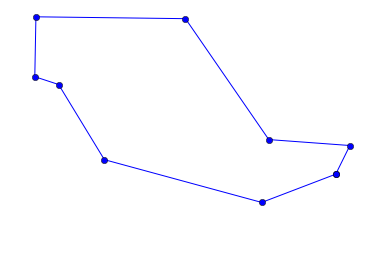

9 city tour with length 2217.5 in 0.213 secs for alltours_tsp


In [26]:
plot_tsp(alltours_tsp, Cities(9))

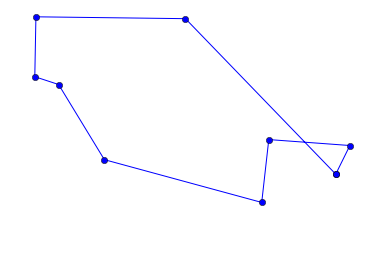

9 city tour with length 2361.1 in 0.000 secs for nn_tsp


In [27]:
plot_tsp(nn_tsp, Cities(9))

So the nearest neighbor approach was a lot faster, but it didn't find the shortest tour. To understand where it went wrong, it would be helpful to know what city it started from.  I can modify `plot_tour` by adding one line of code to highlight the start city with a red square:

In [28]:
def plot_tour(tour):
    "Plot the cities as circles and the tour as lines between them. Start city is red square."
    start = tour[0]
    plot_lines(list(tour) + [start])
    plot_lines([start], 'rs') # Mark the start city with a red square

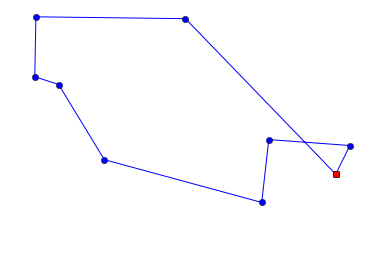

9 city tour with length 2361.1 in 0.000 secs for nn_tsp


In [29]:
plot_tsp(nn_tsp, Cities(9))

We can see that the tour moves clockwise from the start city, and mostly makes good decisions, but not optimal ones.

We can compare the performance of these two algorithms on, say, eleven different sets of cities instead of just one:

In [30]:
def length_ratio(cities): 
    "The ratio of the tour lengths for nn_tsp and alltours_tsp algorithms."
    return tour_length(nn_tsp(cities)) / tour_length(alltours_tsp(cities))

sorted(length_ratio(Cities(8, seed=i)) for i in range(11))

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0060657396717771,
 1.0476876839109404,
 1.061687777368538,
 1.0980209876906022,
 1.137595917252964,
 1.1545257527154165]

The ratio of `1.0` means the two algorithms got the same (optimal) result; that happened 5 times out of 10.  The other times, we see that the `nn_tsp` produces a longer tour, by anything up to 15% worse, with a median of 0.6% worse.

But more important than that 0.6% (or even 15%) difference is that the nearest neighbor algorithm can quickly tackle problems that the all tours algorithm can't touch in the lifetime of the universe.  Finding a tour of 1000 cities takes well under a second:

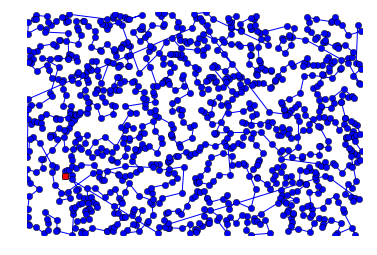

1000 city tour with length 21523.4 in 0.217 secs for nn_tsp


In [31]:
plot_tsp(nn_tsp, Cities(1000))

Can we do better?   Can we combine the speed of the nearest neighbor algorithm with the optimality of the all tours algorithm? 

Let's consider what went wrong with `nn_tsp`. Looking at `plot_tsp(nn_tsp, Cities(100))`, we see that near the end of the tour there are some very long edges between cities, because there are no remaining cities near by.  In a way, this just seems like bad luck&mdash;the way we flow from neighbor to neighbor just happens to leave a few very-long edges.  Just as with buying lottery tickets, we could improve our chance of winning by trying more often; in other words, by using the **repetition strategy**.

## Repeated Nearest Neighbor Algorithm (repeated_nn_tsp)

Here is an easy way to apply the **repetition** strategy to improve **nearest neighbors**:

> *Repeated Nearest Neighbor Algorithm: For each of the cities, run the nearest neighbor algorithm with that city as the starting point, and choose the resulting tour with the shortest total distance.*

So, with *n* cities we could run the `nn_tsp` algorithm *n* times, regrettably making the total run time *n* times longer, but hopefully making at least one of the *n* tours shorter. 

To implement  `repeated_nn_tsp` we just take the shortest tour over all starting cities:

In [32]:
def repeated_nn_tsp(cities):
    "Repeat the nn_tsp algorithm starting from each city; return the shortest tour."
    return shortest_tour(nn_tsp(cities, start) 
                         for start in cities)

To do that requires a modification of `nn_tsp` so that the `start` city can be specified as an optional argument:

In [33]:
def nn_tsp(cities, start=None):
    """Start the tour at the first city; at each step extend the tour 
    by moving from the previous city to its nearest neighbor 
    that has not yet been visited."""
    if start is None: start = first(cities)
    tour = [start]
    unvisited = set(cities - {start})
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

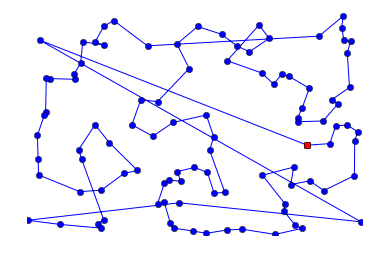

100 city tour with length 8447.8 in 0.004 secs for nn_tsp


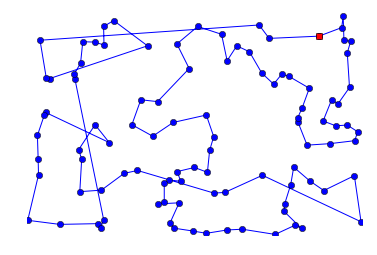

100 city tour with length 6996.7 in 0.227 secs for repeated_nn_tsp


In [34]:
# Compare nn_tsp to repeated_nn_tsp
plot_tsp(nn_tsp, Cities(100))
plot_tsp(repeated_nn_tsp, Cities(100))

We see that `repeated_nn_tsp` does indeed take longer to run, and yields a tour that is shorter.  

Let's try again with a smaller map that makes it easier to visualize the tours:

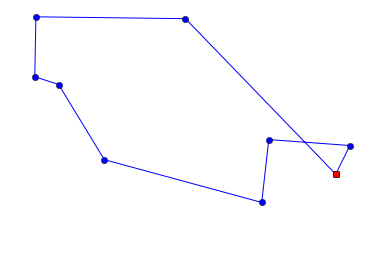

9 city tour with length 2361.1 in 0.000 secs for nn_tsp


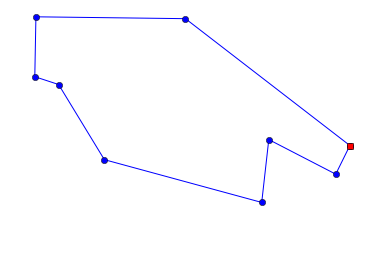

9 city tour with length 2322.1 in 0.001 secs for repeated_nn_tsp


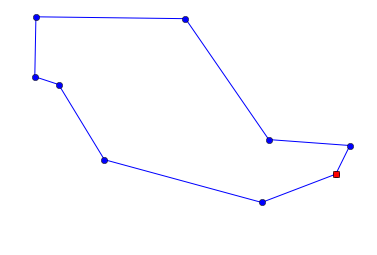

9 city tour with length 2217.5 in 0.202 secs for alltours_tsp


In [35]:
plot_tsp(nn_tsp, Cities(9))
plot_tsp(repeated_nn_tsp, Cities(9))
plot_tsp(alltours_tsp, Cities(9))

This time the `repeated_nn_tsp` gives us a tour that is better tha `nn_tsp`, but not quite optimal.  So, it looks like repetition is helping.  But if I want to tackle 1000 cities, I don't really want the run time to be 1000 times slower.  I'd like a way to moderate the repetition&mdash;to repeat the `nn_tsp` starting from *a sample* of the cities but not *all* the cities.

Sampled Repeated Nearest Neighbor Algorithm (improved `repeated_nn_tsp`)
---

We can give `repeated_nn_tsp` an optional argument specifying the number of different cities to try starting from. We will implement the function `sample` to draw a random sample of the specified size from all the cities.  Most of the work is done by the standard library function `random.sample`. What our `sample` adds is the same thing we did with the function `Cities`: we ensure that the function returns the same result each time for the same arguments, but can return different results if a `seed` parameter is passed in.  (In addition, if the sample size, `k` is `None` or is larger than the population, then return the whole population.)

In [36]:
def repeated_nn_tsp(cities, repetitions=100):
    "Repeat the nn_tsp algorithm starting from specified number of cities; return the shortest tour."
    return shortest_tour(nn_tsp(cities, start) 
                         for start in sample(cities, repetitions))

def sample(population, k, seed=42):
    "Return a list of k elements sampled from population. Set random.seed with seed."
    if k is None or k > len(population): 
        return population
    random.seed(len(population) * k * seed)
    return random.sample(population, k)

Let's compare with 1, 10, and 100 starting cities on a 300 city map:

In [37]:
def repeat_10_nn_tsp(cities): return repeated_nn_tsp(cities, 10)
def repeat_100_nn_tsp(cities): return repeated_nn_tsp(cities, 100)

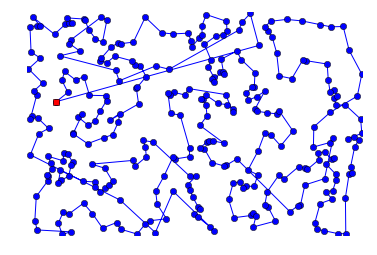

300 city tour with length 11503.8 in 0.033 secs for nn_tsp


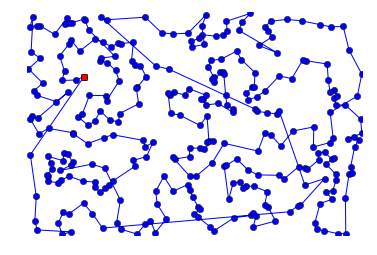

300 city tour with length 11454.3 in 0.194 secs for repeat_10_nn_tsp


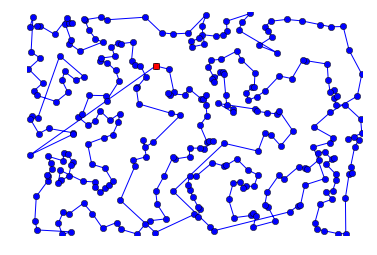

300 city tour with length 11194.7 in 1.304 secs for repeat_100_nn_tsp


In [38]:
plot_tsp(nn_tsp, Cities(300))
plot_tsp(repeat_10_nn_tsp, Cities(300))
plot_tsp(repeat_100_nn_tsp, Cities(300))

As we add more starting cities, the run times get longer and the tours get shorter.

I'd like to understand the tradefoff better.  I'd like to have a way to compare different algorithms (or different choices of parameters for one algorithm) over *multiple* trials, and summarize the results.  I'll get to that soon, but first a brief diversion for more vocabulary.

New Vocabulary: Maps
---

We use the term *cities* and the function `Cities` to denote a set of cities.  But now I want to talk about multiple trials over a collection of sets of cities: a plural of a plural.  English doesn't give us a good way to do that, so it would be nice to have a *singular* noun that is a synonym for "set of cities."  We'll use the term "map" for this, and the function `Maps` to create a collection of maps.  Just like `Cities`, the function `Maps` will give the same result every time it is called with the same arguments.

In [39]:
def Maps(num_maps, num_cities):
    "Return a list of maps, each consisting of the given number of cities."
    return tuple(Cities(num_cities, seed=(m, num_cities))
                 for m in range(num_maps))

Benchmarking (Any Function)
---

The term *benchmarking* means running a function on a standard collection of inputs, in order to compare its performance. We'll define a general-purpose function, `benchmark`, which takes a function and a collection of inputs for that function, and runs the function on each of the inputs.  It then returns two values: the average time taken per input, and the list of results of the function.

In [40]:
def benchmark(function, inputs):
    "Run function on all the inputs; return pair of (average_time_taken, results)."
    t0           = time.clock()
    results      = map(function, inputs)
    t1           = time.clock()
    average_time = (t1 - t0) / len(inputs)
    return (average_time, results)

We can use `benchmark` to see that the abolute value function takes less than a microsecond:

In [41]:
benchmark(abs, range(-10, 10))

(2.000000000279556e-07,
 [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

And we can see that `alltours_tsp` can handle 6-city maps in about a millisecond each:

In [42]:
benchmark(alltours_tsp, Maps(10, 6))

(0.0011380000000000834,
 [[(654+277j), (508+326j), (208+535j), (188+480j), (156+351j), (595+162j)],
  [(100+74j), (595+166j), (810+232j), (381+309j), (379+432j), (147+593j)],
  [(502+121j), (380+210j), (237+277j), (272+467j), (531+557j), (889+424j)],
  [(245+540j), (598+423j), (896+240j), (302+321j), (150+406j), (11+376j)],
  [(862+280j), (710+441j), (652+440j), (405+598j), (362+42j), (755+142j)],
  [(593+177j), (591+247j), (757+499j), (721+520j), (57+379j), (535+204j)],
  [(253+77j), (242+298j), (34+377j), (283+545j), (529+364j), (827+8j)],
  [(424+468j), (183+486j), (173+489j), (20+349j), (276+316j), (400+312j)],
  [(669+590j), (790+529j), (507+186j), (80+41j), (240+328j), (505+564j)],
  [(410+69j), (555+162j), (581+497j), (16+339j), (337+163j), (385+127j)]])

Caching (or *Memoization*) of Function Results
---

Here's an issue about benchmarking: each time we develop a new algorithm, we would like to compare its performance to some standard old algorithms. It seems a waste of computer time to re-run the old algorithms on a standard data set each time. And it seems like a waste of human time to scroll back up and check (e.g. "How did `nn_tsp` do on `Maps(30, 60)`? Where was that?"). It would be better if the `benchmark` function could *remember* the (function, inputs) pairs that it has already run, and when asked for the same pair over again, just go look up the results rather than re-computing the results. 

The process of taking a function (such as `benchmark`) and making it remember its previously-computed results is called **memoization**.  The idea is that we do:

    benchmark = memoize(benchmark)
    
and now when we call `benchmark(function, test_cases)` the first time it will be computed just like before, but when we make the same call a second time, the result will be instanly looked up rather than laboriously re-computed.

Here is one way to implement the function `memoized` so that `memoized(func)` creates a new function that acts just like `func` except that it stores results in a table, called a *cache*: 

In [43]:
def memoize(func):
    "Return a version of func that remembers the output for each input."
    cache = {}
    def new_func(*args):
        try:
            # If we have already computed func(*args), just return it
            return cache[args]
        except TypeError:
            # If args are not hashable, compute func(*args) and return it
            return func(*args)
        except KeyError:
            # If args are hashable, compute func(*args) and store it
            cache[args] = func(*args)
            return cache[args] 
    new_func._cache   = cache
    new_func.__doc__  = func.__doc__
    new_func.__name__ = func.__name__
    return new_func

There are three paths through the function: 

1. If the tuple `args` is already in the cache, then look it up and return it.
2. A `TypeError` means that one of the `args` is not hashable; in that case we just call `func(*args)` and return it. We can't do caching in this case.
3. A `KeyError` means that `args` are hashable, but have not yet been seen. So compute `func(*args)`, store the result in the cache, and return it.

We also copy over the documentation and function name from the old `func` to the new memoized function, and store the cache there as well, so that, if we want to to, we could do `benchmark._cache.clear()`.

We could now do "`benchmark = memoize(benchmark)`", or more Pythonically, use the [decorator](https://docs.python.org/2/reference/compound_stmts.html#function) syntax:

In [44]:
@memoize
def benchmark(function, inputs):
    "Run function on all the inputs; return pair of (average_time_taken, results)."
    t0           = time.clock()
    results      = map(function, inputs)
    t1           = time.clock()
    average_time = (t1 - t0) / len(inputs)
    return (average_time, results)

Here we see that the first call to `benchmark` takes 5 seconds, while the second repeated call takes only microseconds but correctly delivers the same result:

In [45]:
%time benchmark(alltours_tsp, Maps(2, 10))

CPU times: user 3.22 s, sys: 65.8 ms, total: 3.28 s
Wall time: 3.22 s


(1.6421194999999997,
 [[(664+505j),
   (617+543j),
   (500+564j),
   (57+539j),
   (98+220j),
   (797+56j),
   (781+126j),
   (583+264j),
   (485+435j),
   (587+492j)],
  [(560+80j),
   (743+218j),
   (461+142j),
   (420+268j),
   (153+264j),
   (152+251j),
   (297+73j),
   (363+53j),
   (434+55j),
   (482+20j)]])

In [46]:
%time benchmark(alltours_tsp, Maps(2, 10))

CPU times: user 86 µs, sys: 27 µs, total: 113 µs
Wall time: 98.9 µs


(1.6421194999999997,
 [[(664+505j),
   (617+543j),
   (500+564j),
   (57+539j),
   (98+220j),
   (797+56j),
   (781+126j),
   (583+264j),
   (485+435j),
   (587+492j)],
  [(560+80j),
   (743+218j),
   (461+142j),
   (420+268j),
   (153+264j),
   (152+251j),
   (297+73j),
   (363+53j),
   (434+55j),
   (482+20j)]])

Benchmarking (TSP Algorithms)
---

Now let's add another function, `benchmarks`, which builds on `benchmark` in two ways:

1. It compares multiple algorithms, rather than just running one algorithm. (Hence the plural `benchmarks`.)
2. It is specific to `TSP` algorithms, and rather than returning results, it prints summary statistics: the mean, standard deviation, min, and max of tour lengths, as well as the time taken and the number and size of the sets of cities.

In [47]:
def benchmarks(tsp_algorithms, maps=Maps(30, 60)):
    "Print benchmark statistics for each of the algorithms."    
    for tsp in tsp_algorithms:
        time, results = benchmark(tsp, maps)
        lengths = map(tour_length, results)
        print("{:>25} |{:7.1f} ±{:4.0f} ({:5.0f} to {:5.0f}) |{:7.3f} secs/map | {} ⨉ {}-city maps"
              .format(tsp.__name__, mean(lengths), stddev(lengths), min(lengths), max(lengths),
                      time, len(maps), len(maps[0])))

Here are two functions to do simple statistics:

In [48]:
def mean(numbers): return sum(numbers) / len(numbers)

def stddev(numbers):
    "The standard deviation of a collection of numbers."
    return (mean([x ** 2 for x in numbers]) - mean(numbers) ** 2) ** 0.5

How Many Starting Cities is best for `nn_tsp`?
---

Now we are in a position to gain some insight into how many repetitions, or starting cities, we need to get a good result from `nn_tsp`.

In [49]:
def repeat_25_nn_tsp(cities): return repeated_nn_tsp(cities, 25)
def repeat_50_nn_tsp(cities): return repeated_nn_tsp(cities, 50)

In [50]:
algorithms = [nn_tsp, repeat_10_nn_tsp, repeat_25_nn_tsp, repeat_50_nn_tsp, repeat_100_nn_tsp]

benchmarks(algorithms)

                   nn_tsp | 5689.8 ± 487 ( 4536 to  6861) |  0.001 secs/map | 30 ⨉ 60-city maps
         repeat_10_nn_tsp | 5238.1 ± 396 ( 4150 to  5977) |  0.006 secs/map | 30 ⨉ 60-city maps
         repeat_25_nn_tsp | 5137.2 ± 375 ( 4071 to  6181) |  0.014 secs/map | 30 ⨉ 60-city maps
         repeat_50_nn_tsp | 5123.1 ± 358 ( 4071 to  5977) |  0.029 secs/map | 30 ⨉ 60-city maps
        repeat_100_nn_tsp | 5116.0 ± 352 ( 4071 to  5977) |  0.033 secs/map | 30 ⨉ 60-city maps


We see that adding more starting cities results in shorter tours, but you start getting diminishing returns after 25 or 50 repetitions.

Let's try again with bigger maps:

In [51]:
benchmarks(algorithms, Maps(30, 120))

                   nn_tsp | 7843.8 ± 457 ( 6993 to  8983) |  0.005 secs/map | 30 ⨉ 120-city maps
         repeat_10_nn_tsp | 7361.4 ± 365 ( 6824 to  8157) |  0.021 secs/map | 30 ⨉ 120-city maps
         repeat_25_nn_tsp | 7249.5 ± 353 ( 6527 to  7984) |  0.052 secs/map | 30 ⨉ 120-city maps
         repeat_50_nn_tsp | 7230.6 ± 336 ( 6647 to  7969) |  0.123 secs/map | 30 ⨉ 120-city maps
        repeat_100_nn_tsp | 7201.4 ± 345 ( 6527 to  7957) |  0.283 secs/map | 30 ⨉ 120-city maps


In [52]:
benchmarks(algorithms, Maps(30, 150))

                   nn_tsp | 8657.3 ± 417 ( 7743 to  9323) |  0.006 secs/map | 30 ⨉ 150-city maps
         repeat_10_nn_tsp | 8268.5 ± 357 ( 7637 to  9260) |  0.040 secs/map | 30 ⨉ 150-city maps
         repeat_25_nn_tsp | 8168.0 ± 380 ( 7429 to  9369) |  0.099 secs/map | 30 ⨉ 150-city maps
         repeat_50_nn_tsp | 8091.9 ± 349 ( 7511 to  9250) |  0.199 secs/map | 30 ⨉ 150-city maps
        repeat_100_nn_tsp | 8067.2 ± 351 ( 7409 to  9238) |  0.399 secs/map | 30 ⨉ 150-city maps


The results are similar. So depending on what your priorities are (run time versus tour length), somewhere around 25 or 50 repetitions might be a good tradeoff.

Next let's try to analyze where nearest neighbors goes wrong, and see if we can do something about it.

## A Problem with Nearest Neighbors: Outliers

Consider the 20-city map that we build below:

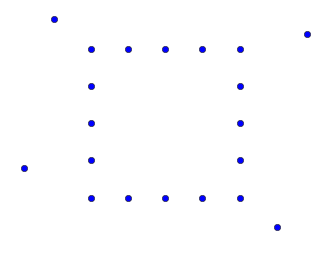

In [53]:
outliers_list = [City(2, 2),  City(2, 3),  City(2, 4),  City(2, 5),  City(2, 6),  
                 City(3, 6),  City(4, 6),  City(5, 6),  City(6, 6),  
                 City(6, 5),  City(6, 4),  City(6, 3),  City(6, 2),  
                 City(5, 2),  City(4, 2),  City(3, 2),  
                 City(1, 6.8),  City(7.8, 6.4),  City(7, 1.2),  City(0.2, 2.8)]

outliers = set(outliers_list)

plot_lines(outliers, 'bo')

Let's see what a nearest neighbor search does on this map:

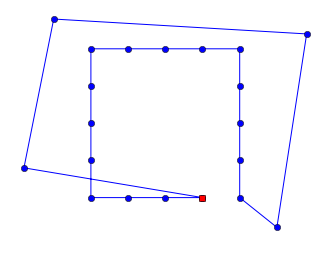

20 city tour with length 37.3 in 0.000 secs for nn_tsp


In [54]:
plot_tsp(nn_tsp, outliers)

The tour starts out going around the inner square.  But then we are left with four long lines to pick up the outliers. 
Let's try to understand what went wrong.  First we'll create a new tool to draw better diagrams:

In [55]:
def plot_labeled_lines(points, *args):
    """Plot individual points, labeled with an index number.
    Then, args describe lines to draw between those points.
    An arg can be a matplotlib style, like 'ro--', which sets the style until changed,
    or it can be a list of indexes of points, like [0, 1, 2], saying what line to draw."""
    # Draw points and label them with their index number
    plot_lines(points, 'bo')
    for (label, p) in enumerate(points):
        plt.text(X(p), Y(p), '  '+str(label))
    # Draw lines indicated by args
    style = 'bo-'
    for arg in args:
        if isinstance(arg, str):
            style = arg
        else: # arg is a list of indexes into points, forming a line
            Xs = [X(points[i]) for i in arg]
            Ys = [Y(points[i]) for i in arg]
            plt.plot(Xs, Ys, style)
    plt.axis('scaled'); plt.axis('off'); plt.show()        

In the diagram below, imagine we are running a nearest neighbor algorithm, and it has created a partial tour from city 0 to city 4.  Now there is a choice.  City 5 is the nearest neighbor.  But if we don't take city 16 at this point, we will have to pay a higher price sometime later to pick up city 16.  

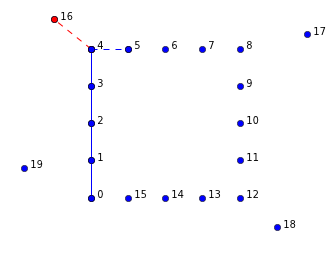

In [56]:
plot_labeled_lines(outliers_list, 'bo-', [0, 1, 2, 3, 4], 'ro--', [4, 16], 'bo--', [4, 5])

It seems that picking up an outlier is *sometimes* a good idea, but sometimes going directly to the nearest neighbor is a better idea. So what can we do?  It is difficult to make the choice between an outlier and a nearest neighbor while we are constructing a tour, because we don't have the context of the whole tour yet. So here's an alternative idea: don't try to make the right choice while constructing the tour; just go ahead and make any choice, then when the tour is complete, *alter* it to correct problems caused by outliers (or other causes).

New Vocabulary: Segment
---

We'll define a *segment* as a subsequence of a tour: a sequence of consecutive cities within a tour. A tour forms a loop, but a segment does not have a loop; it is open-ended on both ends. So, if `[A, B, C, D]` is a 4-city tour, then segments include `[A, B]`, `[B, C, D]`, and many others.  Note that the segment `[A, B, C, D]` is different than the tour `[A, B, C, D]`; the tour returns from `D` to `A` but the segment does not. 

>>> Altering Tours by Reversing Segments
===

One way we could try to improve a tour is by *reversing* a segment.  Consider this tour:

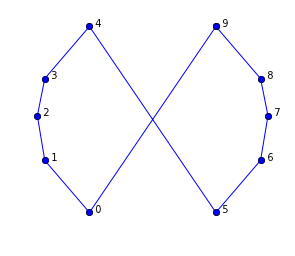

In [57]:
cross = [City(9, 3),  City(3, 10),  City(2, 16),  City(3, 21),  City(9, 28), 
         City(26, 3), City(32, 10), City(33, 16), City(32, 21), City(26, 28)]

plot_labeled_lines(cross, range(-1,10))

This is clearly not an optimal tour.  We should "uncross" the lines, which can be achieved by reversing a segment.  The tour as it stands is `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.  If we reverse the segment `[5, 6, 7, 8, 9]`, we get the tour `[0, 1, 2, 3, 4, 9, 8, 7, 6, 5]`, which is the optimal tour.  In the diagram below, reversing `[5, 6, 7, 8, 9]` is equivalent to deleting the  red  dashed lines and adding the green dotted lines. If the sum of the lengths of the green dotted lines is less than the sum of the lengths of the red dashed lines, then we know the reversal is an improvement.

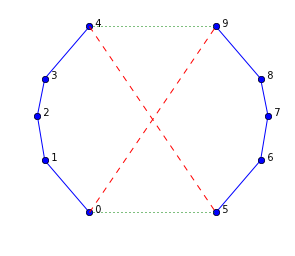

In [58]:
plot_labeled_lines(cross, 'bo-', range(5), range(5, 10), 
                          'g:', (4, 9), (0, 5), 
                          'r--', (4, 5), (0, 9))

Here we see that reversing `[5, 6, 7, 8, 9]` works:

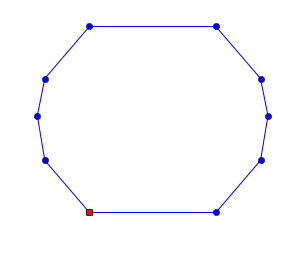

In [59]:
tour = Tour(cross)
tour[5:10] = reversed(tour[5:10])
plot_tour(tour)

Here is how we can check if reversing a segment is an improvement, and if so to do it:

In [60]:
def reverse_segment_if_better(tour, i, j):
    "If reversing tour[i:j] would make the tour shorter, then do it." 
    # Given tour [...A-B...C-D...], consider reversing B...C to get [...A-C...B-D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Are old edges (AB + CD) longer than new ones (AC + BD)? If so, reverse segment.
    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D):
        tour[i:j] = reversed(tour[i:j])

Now let's write a function, `alter_tour`, which finds segments to swap. What segments should we consider? I don't know how to be clever about the choice, but I do know how to be fairly thorough: try all segments of all lengths at all starting positions. I have an intuition that trying longer ones first is better (although I'm not sure). 

I worry that even trying all segements won't be enough: after I reverse one segment, it might open up opportunities to reverse other segments.  So, after trying all possible segments, I'll check the tour length.  If it has been reduced, I'll go through the `alter_tour` process again.

In [61]:
def alter_tour(tour):
    "Try to alter tour for the better by reversing segments."
    original_length = tour_length(tour)
    for (start, end) in all_segments(len(tour)):
        reverse_segment_if_better(tour, start, end)
    # If we made an improvement, then try again; else stop and return tour.
    if tour_length(tour) < original_length:
        return alter_tour(tour)
    return tour

def all_segments(N):
    "Return (start, end) pairs of indexes that form segments of tour of length N."
    return [(start, start + length)
            for length in range(N, 2-1, -1)
            for start in range(N - length + 1)]

Here is what the list of all segments look like, for N=4:

In [62]:
all_segments(4)

[(0, 4), (0, 3), (1, 4), (0, 2), (1, 3), (2, 4)]

We can see that altering the cross tour does straighten it out:

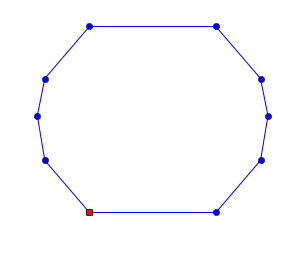

In [63]:
plot_tour(alter_tour(Tour(cross)))

Altered Nearest Neighbor Algorithm (`altered_nn_tsp`)
----

Let's see what happens when we alter the output of `nn_tsp`:

In [64]:
def altered_nn_tsp(cities):
    "Run nearest neighbor TSP algorithm, and alter the results by reversing segments."
    return alter_tour(nn_tsp(cities))

Let's try this new algorithm on some test cases:

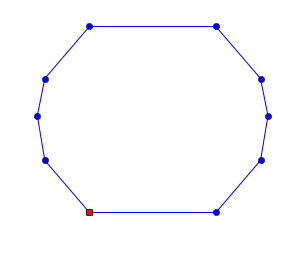

10 city tour with length 93.2 in 0.000 secs for altered_nn_tsp


In [65]:
plot_tsp(altered_nn_tsp, set(cross))

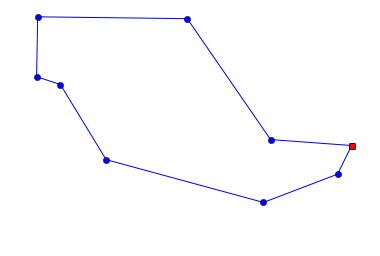

9 city tour with length 2217.5 in 0.000 secs for altered_nn_tsp


In [66]:
plot_tsp(altered_nn_tsp, Cities(9))

It gets the optimal results.  Let's try benchmarking:

In [67]:
algorithms = [nn_tsp, repeat_50_nn_tsp, altered_nn_tsp]

benchmarks(algorithms)

                   nn_tsp | 5689.8 ± 487 ( 4536 to  6861) |  0.001 secs/map | 30 ⨉ 60-city maps
         repeat_50_nn_tsp | 5123.1 ± 358 ( 4071 to  5977) |  0.041 secs/map | 30 ⨉ 60-city maps
           altered_nn_tsp | 4812.1 ± 263 ( 4091 to  5320) |  0.012 secs/map | 30 ⨉ 60-city maps


This is quite encouraging; `altered_nn_tsp` gives shorter tours and is three times faster than repeating nearest neighbors from 50 starting cities. Could we do better?

Altered Repeated Nearest Neighbor Algorithm (`altered_repeated_nn_tsp`)
---

We have seen that the *nearest neighbor* algorithm is improved by both the *alteration* and *repetition* strategies. So why not apply both strategies?  

In [68]:
def repeated_altered_nn_tsp(cities, repetitions=20): 
    "Use alteration to improve each repetition of nearest neighbors."
    return shortest_tour(alter_tour(nn_tsp(cities, start)) 
                         for start in sample(cities, repetitions))

def repeat_5_altered_nn_tsp(cities): return repeated_altered_nn_tsp(cities, 5)

Let's see it in action:

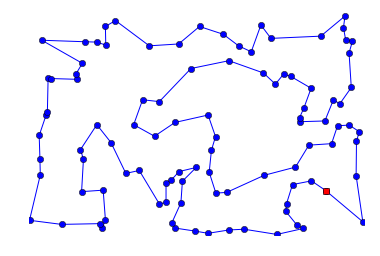

100 city tour with length 5851.6 in 0.831 secs for repeated_altered_nn_tsp


In [69]:
plot_tsp(repeated_altered_nn_tsp, Cities(100))

That looks like a good tour.  Let's gather more data:

In [70]:
algorithms = [nn_tsp, repeat_50_nn_tsp, altered_nn_tsp, repeated_altered_nn_tsp]

benchmarks(algorithms)
print('-' * 100)
benchmarks(algorithms, Maps(30, 120))

                   nn_tsp | 5689.8 ± 487 ( 4536 to  6861) |  0.001 secs/map | 30 ⨉ 60-city maps
         repeat_50_nn_tsp | 5123.1 ± 358 ( 4071 to  5977) |  0.041 secs/map | 30 ⨉ 60-city maps
           altered_nn_tsp | 4812.1 ± 263 ( 4091 to  5320) |  0.012 secs/map | 30 ⨉ 60-city maps
  repeated_altered_nn_tsp | 4628.8 ± 233 ( 3925 to  5120) |  0.238 secs/map | 30 ⨉ 60-city maps
----------------------------------------------------------------------------------------------------
                   nn_tsp | 7843.8 ± 457 ( 6993 to  8983) |  0.004 secs/map | 30 ⨉ 120-city maps
         repeat_50_nn_tsp | 7230.6 ± 336 ( 6647 to  7969) |  0.154 secs/map | 30 ⨉ 120-city maps
           altered_nn_tsp | 6622.8 ± 261 ( 6064 to  7155) |  0.054 secs/map | 30 ⨉ 120-city maps
  repeated_altered_nn_tsp | 6441.1 ± 215 ( 6000 to  6946) |  1.124 secs/map | 30 ⨉ 120-city maps


So, repetition gives us a modest improvement in tour length over the `altered_nn_tsp`, at the cost of 20 times more run time. It looks like the alteration strategy is more powerful than the repetition strategy in this case.

Non-Random Maps
====

I thought it would be fun to work on some *real* maps, instead of random maps. First I found [a page](http://www.realestate3d.com/gps/latlong.htm) that lists geographical coordinates of US cities.  Here is an excerpt from that page:

<pre>
[TCL]  33.23   87.62  Tuscaloosa,AL
[FLG]  35.13  111.67  Flagstaff,AZ
[PHX]  33.43  112.02  Phoenix,AZ
</pre>

I also found a [blog post](http://www.randalolson.com/2015/03/08/computing-the-optimal-road-trip-across-the-u-s/) by Randal S. Olson who chose 50 landmarks across the states and found a tour based on actual road-travel distances, not straight-line distance. His data looks like this:

<pre>
Mount Rushmore National Memorial, South Dakota 244, Keystone, SD	43.879102	-103.459067
Toltec Mounds, Scott, AR	34.647037	-92.065143
Ashfall Fossil Bed, Royal, NE	42.425000	-98.158611
</pre> 
You can't see, but fields are separated by tabs in this data.

Now we have a problem: we have two similar but different data formats, and we want to convert both of them to `Maps` (sets of cities).  Python provides a module, [`csv`](https://docs.python.org/3/library/csv.html) (for "comma-separated values"), to parse data like this.  The function `csv.reader` takes an input that should be an iterable over lines of text, and optionally you can tell it what character to use as a delimiter (as well as several other options). For each line, it generates a
list of fields.  For example, for the line `"[TCL]  33.23   87.62  Tuscaloosa,AL"`  it would generate the list `['[TCL]', '33.23', '87.62', 'Tuscaloosa,AL']`.

I define the function `Coordinate_map` to take an iterable of lines (usually a file object or a list of strings), parse it with `csv_reader`, pick out the latitude and longitude columns, and build a `City` out of each one:

In [71]:
def lines(text): return text.strip().splitlines()

def Coordinate_map(lines, delimiter=' ', lat_col=1, long_col=2, lat_scale=69, long_scale=-48):
    """Make a set of Cities from an iterable of lines of text.
    Specify the column delimiter, and the zero-based column number of lat and long.
    Treat long/lat as a square x/y grid, scaled by long_scale and lat_scale.
    Source can be a file object, or list of lines."""
    return frozenset(City(long_scale * float(row[long_col]), 
                          lat_scale  * float(row[lat_col]))
                     for row in csv.reader(lines, delimiter=delimiter, skipinitialspace=True))

You might be wondering about the `lat_scale=69, long_scale=-48` part. The issue is that we have latitude and longitude for cities, and we want to compute the distance between cities. To do that accurately requires [complicated trigonometry](http://en.wikipedia.org/wiki/Haversine_formula).  But we can get an approximation by assuming the earth is flat, and that latitude and longitude are on a rectangular grid. (This is a bad approximation if you're talking about distances of 10,000 miles, but close enough for 100 miles, as long as you're not too close to the poles.)  I took the latitude of the center of the country (Wichita, KS: latitude 37.65) and plugged it into a [Length Of A Degree Of Latitude
And Longitude Calculator](http://www.csgnetwork.com/degreelenllavcalc.html) to find that, in Wichita, one degree of latitude is 69 miles, and one degree of longitude is 48 miles.  (It is -48 rather than +48 because the US is west of the prime meridian.) 

Now let's create the map of USA cities, and find a tour for it:

In [72]:
USA_map = Coordinate_map(lines("""
[TCL]  33.23   87.62  Tuscaloosa,AL
[FLG]  35.13  111.67  Flagstaff,AZ
[PHX]  33.43  112.02  Phoenix,AZ
[PGA]  36.93  111.45  Page,AZ
[TUS]  32.12  110.93  Tucson,AZ
[LIT]  35.22   92.38  Little Rock,AR
[SFO]  37.62  122.38  San Francisco,CA
[LAX]  33.93  118.40  Los Angeles,CA
[SAC]  38.52  121.50  Sacramento,CA
[SAN]  32.73  117.17  San Diego,CA
[SBP]  35.23  120.65  San Luis Obi,CA
[EKA]  41.33  124.28  Eureka,CA
[DEN]  39.75  104.87  Denver,CO
[DCA]  38.85   77.04  Washington/Natl,DC
[MIA]  25.82   80.28  Miami Intl,FL
[TPA]  27.97   82.53  Tampa Intl,FL
[JAX]  30.50   81.70  Jacksonville,FL
[TLH]  30.38   84.37  Tallahassee,FL
[ATL]  33.65   84.42  Atlanta,GA
[BOI]  43.57  116.22  Boise,ID
[CHI]  41.90   87.65  Chicago,IL
[IND]  39.73   86.27  Indianapolis,IN
[DSM]  41.53   93.65  Des Moines,IA
[SUX]  42.40   96.38  Sioux City,IA
[ICT]  37.65   97.43  Wichita,KS
[LEX]  38.05   85.00  Lexington,KY
[NEW]  30.03   90.03  New Orleans,LA
[BOS]  42.37   71.03  Boston,MA
[PWM]  43.65   70.32  Portland,ME
[BGR]  44.80   68.82  Bangor,ME
[CAR]  46.87   68.02  Caribou Mun,ME
[DET]  42.42   83.02  Detroit,MI
[STC]  45.55   94.07  St Cloud,MN
[DLH]  46.83   92.18  Duluth,MN
[STL]  38.75   90.37  St Louis,MO
[JAN]  32.32   90.08  Jackson,MS
[BIL]  45.80  108.53  Billings,MT
[BTM]  45.95  112.50  Butte,MT
[RDU]  35.87   78.78  Raleigh-Durh,NC
[INT]  36.13   80.23  Winston-Salem,NC
[OMA]  41.30   95.90  Omaha/Eppley,NE
[LAS]  36.08  115.17  Las Vegas,NV
[RNO]  39.50  119.78  Reno,NV
[AWH]  41.33  116.25  Wildhorse,NV
[EWR]  40.70   74.17  Newark Intl,NJ
[SAF]  35.62  106.08  Santa Fe,NM
[NYC]  40.77   73.98  New York,NY
[BUF]  42.93   78.73  Buffalo,NY
[ALB]  42.75   73.80  Albany,NY
[FAR]  46.90   96.80  Fargo,ND
[BIS]  46.77  100.75  Bismarck,ND
[CVG]  39.05   84.67  Cincinnati,OH
[CLE]  41.42   81.87  Cleveland,OH
[OKC]  35.40   97.60  Oklahoma Cty,OK
[PDX]  45.60  122.60  Portland,OR
[MFR]  42.37  122.87  Medford,OR
[AGC]  40.35   79.93  Pittsburgh,PA
[PVD]  41.73   71.43  Providence,RI
[CHS]  32.90   80.03  Charleston,SC
[RAP]  44.05  103.07  Rapid City,SD
[FSD]  43.58   96.73  Sioux Falls,SD
[MEM]  35.05   90.00  Memphis Intl,TN
[TYS]  35.82   83.98  Knoxville,TN
[CRP]  27.77   97.50  Corpus Chrst,TX
[DRT]  29.37  100.92  Del Rio,TX
[IAH]  29.97   95.35  Houston,TX
[SAT]  29.53   98.47  San Antonio,TX
[LGU]  41.78  111.85  Logan,UT
[SLC]  40.78  111.97  Salt Lake Ct,UT
[SGU]  37.08  113.60  Saint George,UT
[CNY]  38.77  109.75  Moab,UT
[MPV]  44.20   72.57  Montpelier,VT
[RIC]  37.50   77.33  Richmond,VA
[BLI]  48.80  122.53  Bellingham,WA
[SEA]  47.45  122.30  Seattle,WA
[ALW]  46.10  118.28  Walla Walla,WA
[GRB]  44.48   88.13  Green Bay,WI
[MKE]  42.95   87.90  Milwaukee,WI
[CYS]  41.15  104.82  Cheyenne,WY
[SHR]  44.77  106.97  Sheridan,WY
"""))

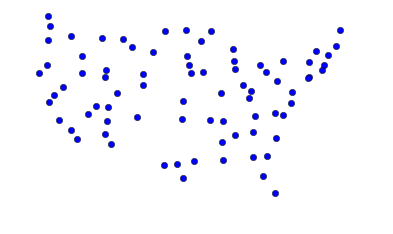

In [73]:
plot_lines(USA_map, 'bo')

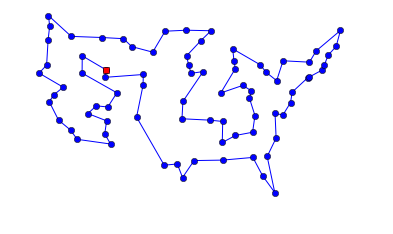

80 city tour with length 13633.0 in 0.471 secs for repeated_altered_nn_tsp


In [74]:
plot_tsp(repeated_altered_nn_tsp, USA_map)

Not bad! There are no obvious errors in the tour (although I'm not at all confident it is the optimal tour). 

Now let's do the same for Randal Olson's landmarks.  Note that the data is delimited by tabs, not spaces, and the longitude already has a minus sign, so we don't need another one in `long_scale`.

In [75]:
USA_landmarks_map = Coordinate_map(lines("""
Mount Rushmore National Memorial, South Dakota 244, Keystone, SD	43.879102	-103.459067
Toltec Mounds, Scott, AR	34.647037	-92.065143
Ashfall Fossil Bed, Royal, NE	42.425000	-98.158611
Maryland State House, 100 State Cir, Annapolis, MD 21401	38.978828	-76.490974
The Mark Twain House & Museum, Farmington Avenue, Hartford, CT	41.766759	-72.701173
Columbia River Gorge National Scenic Area, Oregon	45.711564	-121.519633
Mammoth Cave National Park, Mammoth Cave Pkwy, Mammoth Cave, KY	37.186998	-86.100528
Bryce Canyon National Park, Hwy 63, Bryce, UT	37.593038	-112.187089
USS Alabama, Battleship Parkway, Mobile, AL	30.681803	-88.014426
Graceland, Elvis Presley Boulevard, Memphis, TN	35.047691	-90.026049
Wright Brothers National Memorial Visitor Center, Manteo, NC	35.908226	-75.675730
Vicksburg National Military Park, Clay Street, Vicksburg, MS	32.346550	-90.849850
Statue of Liberty, Liberty Island, NYC, NY	40.689249	-74.044500
Mount Vernon, Fairfax County, Virginia	38.729314	-77.107386
Fort Union Trading Post National Historic Site, Williston, North Dakota 1804, ND	48.000160	-104.041483
San Andreas Fault, San Benito County, CA	36.576088	-120.987632
Chickasaw National Recreation Area, 1008 W 2nd St, Sulphur, OK 73086	34.457043	-97.012213
Hanford Site, Benton County, WA	46.550684	-119.488974
Spring Grove Cemetery, Spring Grove Avenue, Cincinnati, OH	39.174331	-84.524997
Craters of the Moon National Monument & Preserve, Arco, ID	43.416650	-113.516650
The Alamo, Alamo Plaza, San Antonio, TX	29.425967	-98.486142
New Castle Historic District, Delaware	38.910832	-75.527670
Gateway Arch, Washington Avenue, St Louis, MO	38.624647	-90.184992
West Baden Springs Hotel, West Baden Avenue, West Baden Springs, IN	38.566697	-86.617524
Carlsbad Caverns National Park, Carlsbad, NM	32.123169	-104.587450
Pikes Peak, Colorado	38.840871	-105.042260
Okefenokee Swamp Park, Okefenokee Swamp Park Road, Waycross, GA	31.056794	-82.272327
Cape Canaveral, FL	28.388333	-80.603611
Glacier National Park, West Glacier, MT	48.759613	-113.787023
Congress Hall, Congress Place, Cape May, NJ 08204	38.931843	-74.924184
Olympia Entertainment, Woodward Avenue, Detroit, MI	42.387579	-83.084943
Fort Snelling, Tower Avenue, Saint Paul, MN	44.892850	-93.180627
Hoover Dam, Boulder City, CO	36.012638	-114.742225
White House, Pennsylvania Avenue Northwest, Washington, DC	38.897676	-77.036530
USS Constitution, Boston, MA	42.372470	-71.056575
Omni Mount Washington Resort, Mount Washington Hotel Road, Bretton Woods, NH	44.258120	-71.441189
Grand Canyon National Park, Arizona	36.106965	-112.112997
The Breakers, Ochre Point Avenue, Newport, RI	41.469858	-71.298265
Fort Sumter National Monument, Sullivan's Island, SC	32.752348	-79.874692
Cable Car Museum, 94108, 1201 Mason St, San Francisco, CA 94108	37.794781	-122.411715
Yellowstone National Park, WY 82190	44.462085	-110.642441
French Quarter, New Orleans, LA	29.958443	-90.064411
C. W. Parker Carousel Museum, South Esplanade Street, Leavenworth, KS	39.317245	-94.909536
Shelburne Farms, Harbor Road, Shelburne, VT	44.408948	-73.247227
Taliesin, County Road C, Spring Green, Wisconsin	43.141031	-90.070467
Acadia National Park, Maine	44.338556	-68.273335
Liberty Bell, 6th Street, Philadelphia, PA	39.949610	-75.150282
Terrace Hill, Grand Avenue, Des Moines, IA	41.583218	-93.648542
Lincoln Home National Historic Site Visitor Center, 426 South 7th Street, Springfield, IL	39.797501	-89.646211
Lost World Caverns, Lewisburg, WV	37.801788	-80.445630
"""), delimiter='\t', long_scale=48)

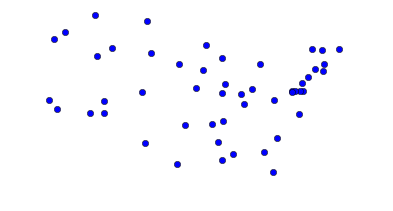

In [76]:
plot_lines(USA_landmarks_map, 'bo')

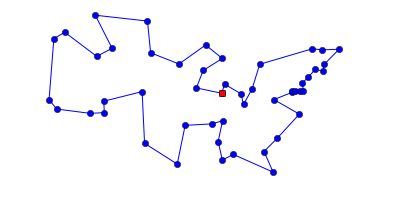

50 city tour with length 10235.3 in 0.205 secs for repeated_altered_nn_tsp


In [77]:
plot_tsp(repeated_altered_nn_tsp, USA_landmarks_map)

We can compare that to the tour that Randal Olson computed as the shortest based on road distances:

<a href="http://www.randalolson.com/2015/03/08/computing-the-optimal-road-trip-across-the-u-s/">
<img src="http://norvig.com/ipython/best-road-trip-major-landmarks.jpg">
</a>

The two tours are similar but not the same.  I think the difference is that roads through the rockies and along the coast of the Carolinas tend to be very windy, so Randal's tour avoids them, whereas my straight-line tour does not. William Cook provides an
analysis, and a [tour that is shorter](http://www.math.uwaterloo.ca/tsp/usa50/index.html) than either Randal's or mine.

Now let's go back to the [original web page](http://www.realestate3d.com/gps/latlong.htm) to get a bigger map with over 1000 cities. I note that the page has some lines that I don't want, so I will filter out lines that are not in the continental US (that is, cities in Alaska or Hawaii), as well as header lines that do not start with `'['`.

In [78]:
url = 'http://www.realestate3d.com/gps/latlong.htm'

def continental_USA(line): 
    "Does line denote a city in the continental United States?"
    return line.startswith('[') and ',AK' not in line and ',HI' not in line

USA_big_map = Coordinate_map(filter(continental_USA, urllib.urlopen(url)))

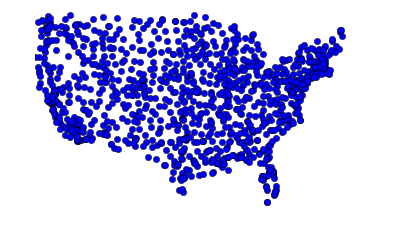

In [79]:
plot_lines(USA_big_map, 'bo')

Let's get a baseline tour with `nn_tsp`:

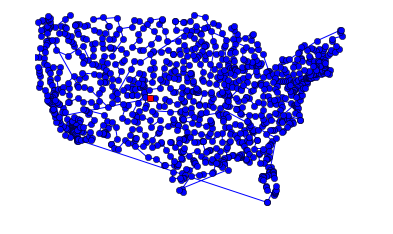

1089 city tour with length 52919.1 in 0.297 secs for nn_tsp


In [80]:
plot_tsp(nn_tsp, USA_big_map)

Now try to improve on that with `repeat_100_nn_tsp` and with `repeat_5_altered_nn_tsp` (which will take a while with over 1000 cities):

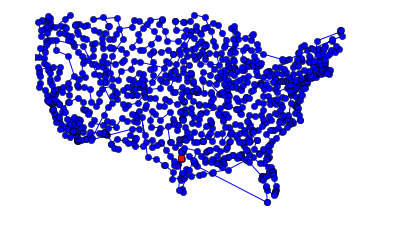

1089 city tour with length 51166.0 in 24.777 secs for repeat_100_nn_tsp


In [81]:
plot_tsp(repeat_100_nn_tsp, USA_big_map)

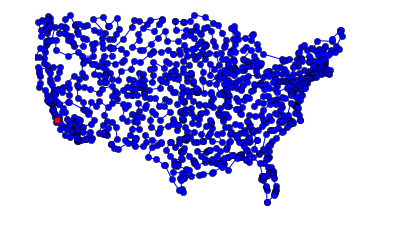

1089 city tour with length 44550.9 in 27.845 secs for repeat_5_altered_nn_tsp


In [82]:
plot_tsp(repeat_5_altered_nn_tsp, USA_big_map)

Again we see that we do better by spending our run time budget on alteration rather than on repetition. This time we saved over 8,000 miles of travel in half a minute!

# >>> Greedy Algorithm (`greedy_tsp`)

At the start of the *Approximate Algorithms* section, we mentioned two ideas:

1. **Nearest Neighbor Algorithm:** Make the tour go from a city to its nearest neighbor. Repeat.
2. **Greedy Algorithm:** Find the shortest distance between any two cities and include that in the tour. Repeat.

It is time to develop the *greedy algorithm*, so-called because at every step it greedily adds to the tour the edge that is shortest (even if that is not best in terms of long-range planning).  The nearest neighbor algorithm always extended the tour by adding on to the end.  The greedy algorithm is different in that it doesn't have a notion of *end* of the tour; instead it keeps a *set* of partial segments. Here's a brief statement of the algorithm:

> *<u>Greedy Algorithm</u>: Maintain a set of segments; intially each city defines its own 1-city segment. Find the shortest possible edge that connects two endpoints of two different segments, and join those segments with that edge. Repeat until we form a segment that tours all the cities.*

On each step of the algorithm, we want to "find the shortest possible edge that connects two endpoints." That seems like an expensive operation to do on each step. So we will add in some data structures to enable us to speed up the computation.  Here's a more detailed sketch of the algorithm:

1. Pre-compute a list of **edges**, sorted by shortest edge first. The list contains one edge for every distinct pair of cities&mdash;if it contains `(A, B)` then it does not contain `(B, A)`, and it never contains `(A, A)`.
2. Maintain a dict that maps **endpoints** to **segments**, e.g. `{A: [A, B, C, D], D: [A, B, C, D]}`. Initially, each city is the endpoint of its own 1-city-long segment, but as we join segments together, some cities are no longer endpoints and are removed from the dict.
3. Go through the edges in shortest-first order. When you find an edge `(A, B)` such that both `A` and `B` are endpoints of different segments, then join the two segments together.  Maintain the endpoints dict to reflect this new segment. Stop when you create
a segment that contains all the cities.


Let's consider an example: assume we have seven cities,  labeled A through G.  Suppose CG happens to be the shortest edge.  We would add the edge to the partial tour, by joining the segment that contains C with the segment that contains G.  In this case, the joining is easy, because each segment is one city long; we join them to form a segment two cities long. We then look at the next shortest edge and continue the process, joining segments as we go, as shown in the table below. Some edges cannot be used.  For example, FD cannot be used, because by the time it becomes the shortest edge, D is already in the interior of a segment. Next, AE cannot be used, even though both A and E are endpoints, because it would make a loop out of ACGDE.  Finally, note that sometimes we may have to reverse a segment.  For example, EF can merge AGCDE and BF, but first we have to reverse BF to FB. 


<table>
<tr><th>Shortest Edge<th>Usage of edge<th>Resulting Segments
<tr><td>&mdash;<td>&mdash;<td> A; B; C; D; E; F; G
<tr><td>CG<td>Join C to G<td>A; B; <b>CG</b>; D; E; F
<tr><td>DE<td>Join D to E<td>A; B; CG; <b>DE</b>; F
<tr><td>AC<td>Join A to CG<td>B; <b>AC</b>G; DE; F
<tr><td>GD<td>Join ACG to D<td>B; AC<b>GD</b>E; F
<tr><td>FD<td>Discard<td>B; ACGDE; F
<tr><td>AE<td>Discard<td>B; ACGDE; F
<tr><td>BF<td>Join B to F<td><b>BF</b>; ACGDE
<tr><td>CF<td>Discard<td>BF; ACGDE
<tr><td>EF<td>Join ACGDE to FB<td>ACGD<b>EF</b>B
</table>

Here is the code:


In [83]:
def greedy_tsp(cities):
    """Go through edges, shortest first. Use edge to join segments if possible."""
    edges = shortest_edges_first(cities) # A list of (A, B) pairs
    endpoints = {c: [c] for c in cities} # A dict of {endpoint: segment}
    for (A, B) in edges:
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints, A, B)
            if len(new_segment) == len(cities):
                return new_segment
            
# TO DO: functions: shortest_edges_first, join_endpoints


**Note:** The `endpoints` dict is serving two purposes. First, the keys of the dict are all the cities that are endpoints of some segments,
making it possible to ask "`A in endpoints`" to see if city `A` is an endpoint. Second, the values of the dict are all the segments, making it possible to ask "`endpoints[A] != endpoints[B]`" to make sure that the two cities endpoints of different segments, not of the same segment.

The `shortest_edges_first` function is easy: generate all `(A, B)` pairs of cities, and sort by the distance between the cities.  (Note: I use the conditional `if id(A) < id(B)` so that I won't have both `(A, B)` and `(B, A)` in my list of edges, and I won't ever have `(A, A)`.)

In [84]:
def shortest_edges_first(cities):
    "Return all edges between distinct cities, sorted shortest first."
    edges = [(A, B) for A in cities for B in cities 
                    if id(A) < id(B)]
    return sorted(edges, key=lambda edge: distance(*edge))

For the `join_endpoints` function, I first make sure that A is the last element of one segment and B is the first element of the other, by reversing segments if necessary.  Then I add the B segment on to the end of the A segment. Finally, I update the `endpoints` dict. This is a bit tricky!  My first thought was that A and B are no longer endpoints, because they have been joined together in the interior of the segment.  However, that isn't always true.  If A was the endpoint of a 1-city segment, then when you join it to B, A is still an endpoint.  I could have had complicated logic to handle the case when A, B, or both, or neither were 1-city segments, but I decided on a different tactic: first unconditionally delete A and B from the endpoints dict, no matter what.  Then add the two endpoints of the new segment (which is `Asegment`) to the endpoints dict.  One or both of them might be A or B, but we don't need conditional logic to check.

In [85]:
def join_endpoints(endpoints, A, B):
    "Join B's segment onto the end of A's and return the segment. Maintain endpoints dict."
    Asegment, Bsegment = endpoints[A], endpoints[B]
    if Asegment[-1] is not A: Asegment.reverse()
    if Bsegment[0] is not B: Bsegment.reverse()
    Asegment.extend(Bsegment)
    del endpoints[A], endpoints[B]
    endpoints[Asegment[0]] = endpoints[Asegment[-1]] = Asegment
    return Asegment

Let's try out the `greedy_tsp` algorithm on the two USA maps:

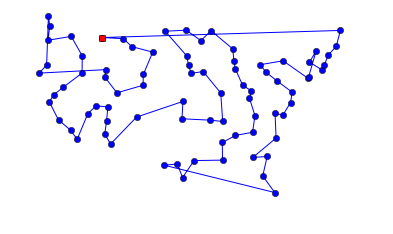

80 city tour with length 16087.5 in 0.007 secs for greedy_tsp


In [86]:
plot_tsp(greedy_tsp, USA_map)

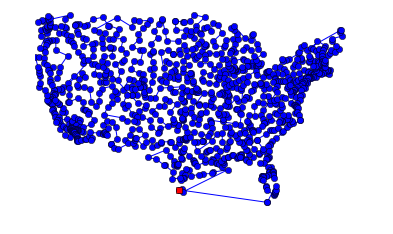

1089 city tour with length 46981.5 in 1.383 secs for greedy_tsp


In [87]:
plot_tsp(greedy_tsp, USA_big_map)

The greedy algorithm is worse than nearest neighbors on the small map, but better on the big one. Let's see if the *alteration* strategy can help:

In [88]:
def altered_greedy_tsp(cities):
    "Run greedy TSP algorithm, and alter the results by reversing segments."
    return alter_tour(greedy_tsp(cities))

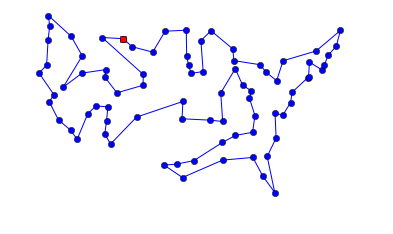

80 city tour with length 14220.1 in 0.052 secs for altered_greedy_tsp


In [89]:
plot_tsp(altered_greedy_tsp, USA_map)

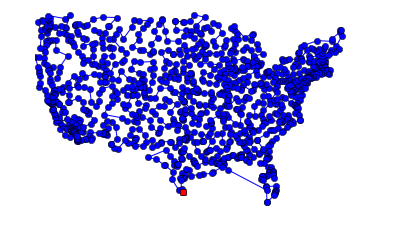

1089 city tour with length 43716.7 in 7.309 secs for altered_greedy_tsp


In [90]:
plot_tsp(altered_greedy_tsp, USA_big_map)

That's the best result yet on the big map. Let's look at some benchmarks:

In [91]:
algorithms = [altered_nn_tsp, altered_greedy_tsp, repeated_altered_nn_tsp]

benchmarks(algorithms)
print('-' * 100)
benchmarks(algorithms, Maps(30, 120))

           altered_nn_tsp | 4812.1 ± 263 ( 4091 to  5320) |  0.012 secs/map | 30 ⨉ 60-city maps
       altered_greedy_tsp | 4780.0 ± 297 ( 3934 to  5383) |  0.013 secs/map | 30 ⨉ 60-city maps
  repeated_altered_nn_tsp | 4628.8 ± 233 ( 3925 to  5120) |  0.238 secs/map | 30 ⨉ 60-city maps
----------------------------------------------------------------------------------------------------
           altered_nn_tsp | 6622.8 ± 261 ( 6064 to  7155) |  0.054 secs/map | 30 ⨉ 120-city maps
       altered_greedy_tsp | 6577.3 ± 223 ( 6184 to  7091) |  0.060 secs/map | 30 ⨉ 120-city maps
  repeated_altered_nn_tsp | 6441.1 ± 215 ( 6000 to  6946) |  1.124 secs/map | 30 ⨉ 120-city maps


So overall, the altered greedy algorithm looks slightly better than the altered nearest neighbor algorithm and runs in about the same time. However, the repeated altered nearest neighbor algorithm does best of all. 

What about a repeated altered greedy algorithm?  That might be a good idea, but there is no obvious way to do it.  We can't just start from a sample of cities, because the greedy algorithm doesn't have a notion of starting city.

Visualizing the Greedy Algorithm
---

I would like to see how the process of joining segments unfolds.  Although I dislike copy-and-paste (because it violates the *[Don't Repeat Yourself](http://en.wikipedia.org/wiki/Don%27t_repeat_yourself)* principle), I'll copy  `greedy_tsp` and make a new version called `visualize_greedy_tsp` which adds one line to plot the segments several times as the algorithm is running:

In [92]:
def visualize_greedy_tsp(cities, plot_sizes):
    """Go through edges, shortest first. Use edge to join segments if possible.
    Plot segments at specified sizes."""
    edges = shortest_edges_first(cities) # A list of (A, B) pairs
    endpoints = {c: [c] for c in cities} # A dict of {endpoint: segment}
    for (A, B) in edges:
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints, A, B)
            plot_segments(endpoints, plot_sizes, distance(A, B)) # <<<< NEW
            if len(new_segment) == len(cities):
                return new_segment
        
def plot_segments(endpoints, plot_sizes, dist):
    "If the number of distinct segments is one of plot_sizes, then plot segments."
    segments = set(map(tuple, endpoints.values()))
    if len(segments) in plot_sizes:
        map(plot_lines, segments); plt.show()
        print('{} segments, longest edge = {:.0f}'.format(
              len(segments), dist))

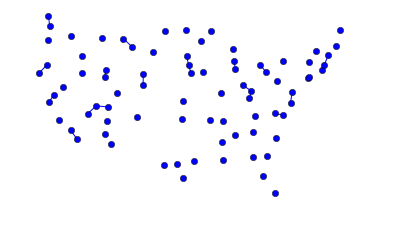

60 segments, longest edge = 104


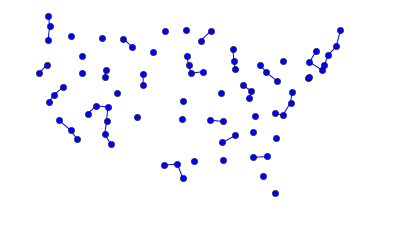

40 segments, longest edge = 148


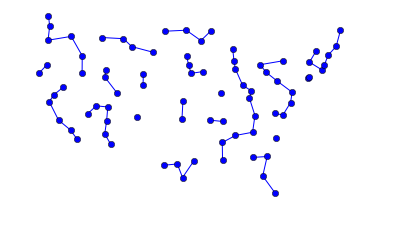

20 segments, longest edge = 210


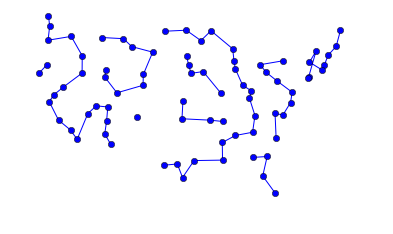

10 segments, longest edge = 255


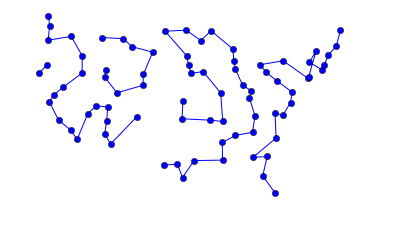

5 segments, longest edge = 335


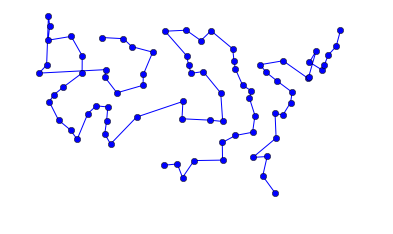

2 segments, longest edge = 597


In [93]:
visualize_greedy_tsp(USA_map, (60, 40, 20, 10, 5, 2));

>>> Divide and Conquer Strategy
===

The next general strategy to consider is *divide and conquer*.  Suppose we have an algorithm, like `alltours_tsp`, that is inefficient for large *n* (the `alltours_tsp` algorithm is O(*n!*) for *n* cities).  So we can't apply `alltours_tsp` directly to a large set of cities.  But we can divide the problem into smaller pieces, and then combine those pieces:

1. Split the set of cities in half.
2. Find a tour for each half.
3. Join those two tours into one.

The trick is that when *n* is small, then step 2 can be done directly.  But when *n* is large, step 2 is done with a recursive call, breaking the half into two smaller halves.

Let's work out by hand an example with a small map of just six cities. Here are the cities:

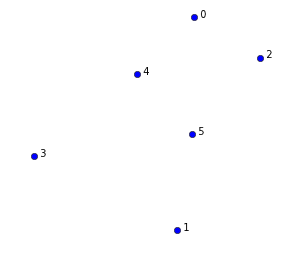

In [94]:
cities = list(Cities(6))
plot_labeled_lines(cities)

Step 1 is to divide this set in half.  I'll divide it into a left half (blue circles) and a right half (black squares):

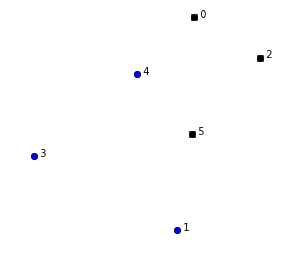

In [95]:
plot_labeled_lines(cities, 'bo', [1, 3, 4], 'ks', [0, 2, 5])

Step 2 is to find a tour for each half:

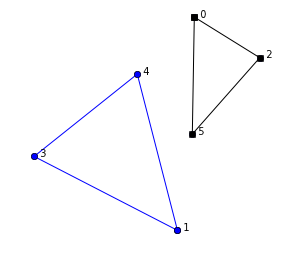

In [96]:
plot_labeled_lines(cities, 'bo-', [1, 3, 4, 1], 'ks-', [0, 2, 5, 0])

Step 3 is to combine the two halves.  We do that by choosing an edge from each half to delete (the edges marked by red dashes) and replacing those two edges by two edges that connect the halves (the blue dash-dot edges). Note that there are two choices of ways to connect the new dash-dot lines.  Out of all the choices, find the one that yields the shortest tour.

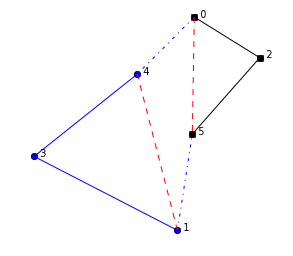

In [97]:
# One way to connect the two segments, giving the tour [1, 3, 4, 0, 2, 5]
plot_labeled_lines(cities, 'bo-', [1, 3, 4], 'ks-', [0, 2, 5],
                   'b-.', [0, 4], [1, 5],
                   'r--', [1, 4], [0, 5])

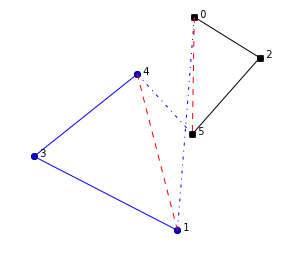

In [98]:
# The other way to connect the two segments, giving the tour [1, 3, 4, 5, 2, 0]
plot_labeled_lines(cities, 'bo-', [1, 3, 4], 'ks-', [0, 2, 5],
                   'b-.', [0, 1], [4, 5],
                   'r--', [1, 4], [0, 5])

Clearly the first way is better than the second.

Now we have a feel for what we have to do.  Let's define the divide and conquer algorithm, which we will call `dq_tsp`. Like all `tsp` algorithms it gets a set of cities as input and returns a tour. If the size of the set of cities is 3 or less, then just listing the cities in any order produces an optimal tour. If there are more than 3 cities, then split the cities in half (using `split_cities`), find a tour for each half (using `dq_tsp` recursively), and join the two tours together (using `join_tours`): 

In [99]:
def dq_tsp(cities):
    """Find a tour by divide and conquer: if number of cities is below threshold,
    find a tour with solver.  Otherwise, split the cities in half, solve each
    half recursively, then join those two tours together."""
    if len(cities) <= 3:
        return Tour(cities)
    else:
        Cs1, Cs2 = split_cities(cities)
        return join_tours(dq_tsp(Cs1), dq_tsp(Cs2))
    
# TO DO: functions: split_cities, join_tours

Let's verify that `dq_tsp` works for three cities:

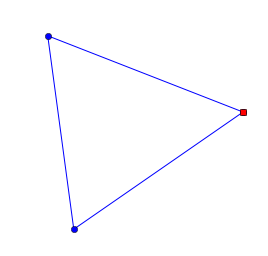

3 city tour with length 328.3 in 0.000 secs for dq_tsp


In [100]:
plot_tsp(dq_tsp, Cities(3))

If we have more than 3 cities, how do we split them?  My approach is to imagine drawing an axis-aligned rectangle that is just big enough to contain all the cities. If the rectangle  is wider than it is tall, then order all the cities by *x* coordiante and split that ordered list in half.  If the rectangle is taller than it is wide, order and split the cities by *y* coordinate. 

In [101]:
def split_cities(cities):
    "Split cities vertically if map is wider; horizontally if map is taller."
    width, height = extent(map(X, cities)), extent(map(Y, cities))
    key = X if (width > height) else Y
    cities = sorted(cities, key=key)
    mid = len(cities) // 2
    return frozenset(cities[:mid]), frozenset(cities[mid:])

def extent(numbers): return max(numbers) - min(numbers)

Let's show that split_cities is working:

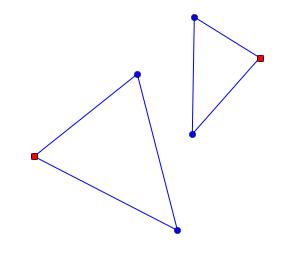

In [102]:
Cs1, Cs2 = split_cities(cities)
plot_tour(dq_tsp(Cs1))
plot_tour(dq_tsp(Cs2))

Now for the tricky part: joining two tours together. First we consider all ways of deleting one edge from each of the two tours.  If we delete a edge from a tour we get a segment.  We are representing segments as lists of cities, the same surface representation as tours.  But there is a difference in their interpretation.  The tour `[0, 2, 5]` is a triangle of three edges, but the segment `[0, 2, 5]` consists of only two edges, from `0` to `2` and from `2` to `5`. The segments that result from deleting an edge from the tour `[0, 2, 5]` are:

<pre>
[0, 2, 5],    [2, 5, 0],    [5, 0, 2]
</pre>

You may recognize these as the *rotations* of the segment `[0, 2, 5]`. So any candidate combined tour consists of taking a rotation of the first tour, and appending to it a rotation of the second tour, with one caveat: when we go to append the two segments, there are two ways of doing it: either keep the second segment as is, or reverse the second segment.

**Note:** In Python, `sequence[::-1]` means to reverse the sequence.

In [103]:
def join_tours(tour1, tour2):
    "Consider all ways of joining the two tours together, and pick the shortest."
    segments1, segments2 = rotations(tour1), rotations(tour2)
    tours = [s1 + s2
             for s1 in segments1
             for s  in segments2
             for s2 in (s, s[::-1])]
    return shortest_tour(tours)

def rotations(sequence):
    "All possible rotations of a sequence."
    # A rotation is some suffix of the sequence followed by the rest of the sequence.
    return [sequence[i:] + sequence[:i] for i in range(len(sequence))]

Let's see if it works, first on the 6 city example:

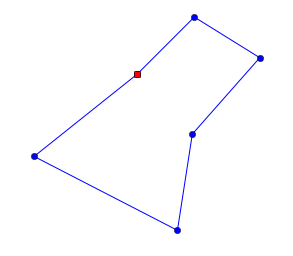

6 city tour with length 1311.1 in 0.000 secs for dq_tsp


In [104]:
plot_tsp(dq_tsp, Cities(6))

That is indeed the optimal tour, achieved by deleting the two dashed red lines and adding the dotted blue lines.

Now for the USA map:

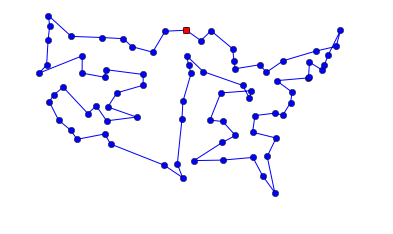

80 city tour with length 14883.2 in 0.199 secs for dq_tsp


In [105]:
plot_tsp(dq_tsp, USA_map)

In [106]:
def altered_dq_tsp(cities): return alter_tour(dq_tsp(cities))

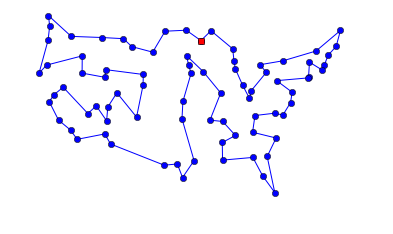

80 city tour with length 14209.6 in 0.193 secs for altered_dq_tsp


In [107]:
plot_tsp(altered_dq_tsp, USA_map)

Let's just remind ourselves how the algorithms behave on the USA map:

In [108]:
algorithms = [nn_tsp, greedy_tsp, dq_tsp, 
              altered_dq_tsp, altered_nn_tsp, altered_greedy_tsp,   
              repeated_altered_nn_tsp]

benchmarks(algorithms, (USA_map,))

                   nn_tsp |15695.3 ±   0 (15695 to 15695) |  0.002 secs/map | 1 ⨉ 80-city maps
               greedy_tsp |16087.5 ±   0 (16088 to 16088) |  0.007 secs/map | 1 ⨉ 80-city maps
                   dq_tsp |14883.2 ±   0 (14883 to 14883) |  0.175 secs/map | 1 ⨉ 80-city maps
           altered_dq_tsp |14209.6 ±   0 (14210 to 14210) |  0.176 secs/map | 1 ⨉ 80-city maps
           altered_nn_tsp |13769.8 ±   0 (13770 to 13770) |  0.027 secs/map | 1 ⨉ 80-city maps
       altered_greedy_tsp |14220.1 ±   0 (14220 to 14220) |  0.029 secs/map | 1 ⨉ 80-city maps
  repeated_altered_nn_tsp |13633.0 ±   0 (13633 to 13633) |  0.454 secs/map | 1 ⨉ 80-city maps


And on the standard test cases:

In [109]:
benchmarks(algorithms)

                   nn_tsp | 5689.8 ± 487 ( 4536 to  6861) |  0.001 secs/map | 30 ⨉ 60-city maps
               greedy_tsp | 5312.9 ± 462 ( 4404 to  6262) |  0.003 secs/map | 30 ⨉ 60-city maps
                   dq_tsp | 5202.4 ± 251 ( 4479 to  5574) |  0.067 secs/map | 30 ⨉ 60-city maps
           altered_dq_tsp | 4879.8 ± 290 ( 4180 to  5409) |  0.077 secs/map | 30 ⨉ 60-city maps
           altered_nn_tsp | 4812.1 ± 263 ( 4091 to  5320) |  0.012 secs/map | 30 ⨉ 60-city maps
       altered_greedy_tsp | 4780.0 ± 297 ( 3934 to  5383) |  0.013 secs/map | 30 ⨉ 60-city maps
  repeated_altered_nn_tsp | 4628.8 ± 233 ( 3925 to  5120) |  0.238 secs/map | 30 ⨉ 60-city maps


Of the non-altered algorithms (the first three lines), divide and conquer (`dq_tsp`) does best.  But interestingly, divide and conquer is helped less by `alter_tour` than is the greedy algorithm or nearest neighbor algorithm.  Perhaps it is because divide and conquer constructs its tour by putting together pieces that are already good, so `alter_tour` is less able to improve it. ALso, `dq_tsp` has a standard deviation that is much smaller than the other two&mdash;this suggests that `dq_tsp` is not producing really bad tours that can be easily improved by `alter_tour`.  In any event, `altered_dq_tsp` is the worst of the `altered` algorithms, both in average tour length and in run time.  

`repeated_altered_nn_tsp` remains the best in tour length, although the worst in run time.

>>> Shoulders of Giants: Minimum Spanning Tree Traversal Algorithm (`mst_tsp`)
===


<a href="http://www.nytimes.com/2007/01/13/obituaries/13kruskal.html?_r=0">
<img src="http://graphics8.nytimes.com/images/2007/01/13/us/13kruskal.jpg">
<br>Kruskal (New York Times)</a>


I hope you now believe that you could have come up with some ideas for solving the TSP. But even if you can't come up with something all on your own, you can always [Google it](http://bit.ly/XNGt2y), in which case you'll no doubt find a giant of a mathematician, [Joseph Kruskal](http://en.wikipedia.org/wiki/Joseph_Kruskal), who, in 1956, 
published [a paper](http://www.cmat.edu.uy/~marclan/TAG/Sellanes/Kruskal.pdf) that led to an algorithm that
most people would not have thought of on their own
 (I know I wouldn't have):
> *<u>Minimum Spanning Tree Traversal Algorithm</u>: Construct a Minimum Spanning Tree, then do a pre-order traversal.  That will give you a tour that is guaranteed to be no more than twice as long as the minimal tour.* 

What does all this jargon mean? It is part of *graph theory*, the study of vertexes and edges.  Here is a glossary of terms:

* A **graph** is a collection of vertexes and edges.
* A **vertex** is a point (such as a city).
* An **edge** is a link between two vertexes. Edges have lengths.

* A **directed graph** is a graph where the edges have a direction.  Think of them as arrows. We say that the edge goes from the **parent** vertex to the **child** vertex.

* A **tree** is a directed graph in which there is one distinguished vertex called the **root** that has no parent; every other vertex has exactly one parent. 

* A **spanning tree** (of a set of vertexes) is a tree that contains all the vertexes.    

* A **minimum spanning tree** is a spanning tree with the smallest possible sum of edge lengths.

* A **traversal** of a tree is a way of visiting all the vertexes in some order.

* A **pre-order traversal** means that you visit the root first, then do a pre-order traversal of each of the children.

* A **guarantee** means that, no matter what set of cities is selected, the tour found by the minimum spanning tree traversal algorithm will never be more than twice as long as the optimal algorithm. None of the other algorithms has any guarantee at all (except of course for `alltours_tsp`, which is guaranteed to find the optimal algorithm, if it has enough time to complete).

We will implement a vertex as a Point, and a directed graph as a dict of `{parent: [child, ...]}` pairs. 

Visualizing Graphs and Trees
---

I think we will need visualization right away, so before doing anything else I will define `plot_graph`. I will make it plot in red so that we can easily tell a tour (blue) from a graph (red).

In [110]:
def plot_graph(graph):
    "Given a graph of the form {parent: [child...]}, plot the vertexes and edges."
    vertexes = {v for parent in graph for v in graph[parent]} | set(graph)
    edges = {(parent, child) for parent in graph for child in graph[parent]}
    for edge in edges:
        plot_lines(edge, 'ro-')
    total_length = sum(distance(p, c) for (p, c) in edges)
    print('{} node Graph of total length: {:.1f}'.format(len(vertexes), total_length))

Let's try it out:

8 node Graph of total length: 10.9


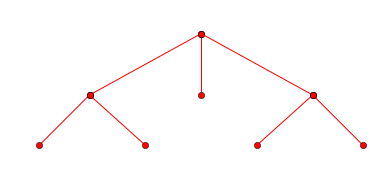

In [111]:
P = [Point(0, 0.1), 
     Point(-2, -1), Point(0, -1), Point(2, -1), 
     Point(-2.9, -1.9), Point(-1, -1.9), Point(1, -1.9), Point(2.9, -1.9)]

Ptree = {P[0]: P[1:4], P[1]: P[4:6], P[3]: P[6:8]}

plot_graph(Ptree)

Now our plan is:

1. Implement an algorithm to create a minimum spanning tree.
2. Implement a tree traversal; that will give us our `mst_tsp` algorithm.
3. Understand the guarantee,  

Creating a Minimum Spanning Tree (`mst`)
---

Now let's see how to create a minimum spanning tree (or MST).  Kruskal has a very nice algorithm to find MSTs, but with what we have done so far, it will be a bit easier to implement another Giant's algorithm:

> *[Prim's algorithm for creating a MST](http://en.wikipedia.org/wiki/Prim%27s_algorithm): List all the edges and sort them, shortest first.  Initialize a tree to be a single root city (we'll arbitrarily shoose the first city). Now repeat the following until the tree contains all the cities: find the shortest edge that links a city (A) that is in the tree to a city (B) that is not yet in the tree, and add B to the list of A's children in the tree.*

Here's the code. One tricky bit: In the first line inside the `while` loop, we define `(A, B)` to be an edge in which one of `A` or `B` is in the tree, using the exclusive-or operator, `^`.  Then in the next line, we make sure that `A` is the one that is in the tree and B is not, by swapping if necessary.

In [112]:
def mst(vertexes):
    """Given a set of vertexes, build a minimum spanning tree: a dict of the form {parent: [child...]}, 
    where parent and children are vertexes, and the root of the tree is first(vertexes)."""
    tree  = {first(vertexes): []} # the first city is the root of the tree.
    edges = shortest_edges_first(vertexes)
    while len(tree) < len(vertexes):
        (A, B) = shortest_usable_edge(edges, tree)
        tree[A].append(B)
        tree[B] = []
    return tree

def shortest_usable_edge(edges, tree):
    "Find the ehortest edge (A, B) where A is in tree and B is not."
    (A, B) = first((A, B) for (A, B) in edges if (A in tree) ^ (B in tree)) # ^ is "xor" 
    return (A, B) if (A in tree) else (B, A)

Let's see what a minimum spanning tree looks like:

80 node Graph of total length: 11518.4


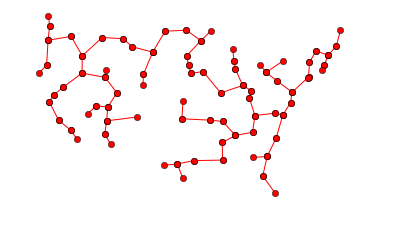

In [113]:
plot_graph(mst(USA_map))

This algorithm clearly produced a spanning tree.  It looks pretty good, but how can we be sure the algorithm will *always* produce a minimum spanning tree?  

1. The output is a **tree** because (1) every city is connected by a path from the root, and (2) every city only gets one parent (we only add a B that is not in tree), so there can be no loops. 
2. The output is a **spanning tree** because it contains all the cities.
3. The output is a **minimum spanning tree** because each city was added with the shortest possible edge.  Suppose this algorithm produces the tree T. For another putative spanning tree to be shorter, it would have to contain at least one city C whose edge from the parent was shorter than the edge in T. But that is not possible, because the algorithm always chooses the shortest possible edge from C's parent to C.



**Note:** There are refinements to Prim's algorithm to make it more efficient.  I won't bother with them because they complicate the code, and because `mst` is already fast enough for our purposes.

Turning a Minimum Spanning Tree into a Tour (`mst_tsp`)
---

Given a minimum spanning tree, we can generate a tour by doing a pre-order traversal, which means the tour starts at the root, then visits all the cities in the pre-order traversal of the first child of the root, followed by the pre-order traversals of any other children.

In [114]:
def mst_tsp(cities):
    "Create a minimum spanning tree and walk it in pre-order, omitting duplicates."
    return preorder_traversal(tree=mst(cities), root=first(cities))

def preorder_traversal(tree, root):
    "Traverse tree in pre-order, starting at root of tree."
    result = [root]
    for child in tree.get(root, ()):
        result.extend(preorder_traversal(tree, child))
    return result

To better understand pre-order traversal, let's go back to the `Ptree` example, and this time label the vertexes:

8 node Graph of total length: 10.9


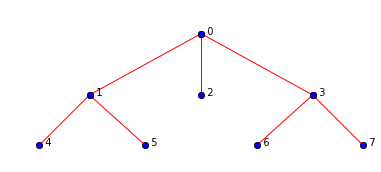

In [115]:
P = [Point(0, 0.1), 
     Point(-2, -1), Point(0, -1), Point(2, -1), 
     Point(-2.9, -1.9), Point(-1, -1.9), Point(1, -1.9), Point(2.9, -1.9)]

Ptree = {P[0]: P[1:4], P[1]: P[4:6], P[3]: P[6:8]}

plot_graph(Ptree)
plot_labeled_lines(P)

A pre-order traversal starting at 0 would go to the first child, 1, then to its children, 4 and 5, then since there are no children of 4 and 5, it would continue with the other children of 0, hitting 2, then 3, and finally the children of 3, namely 6 and 7.  So the following should be true:

In [116]:
preorder_traversal(Ptree, P[0]) == [P[0], P[1], P[4], P[5], P[2], P[3], P[6], P[7]]

True

And this is what the pre-order traversal looks like as a tour:

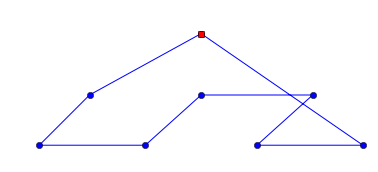

In [117]:
plot_tour([P[0], P[1], P[4], P[5], P[2], P[3], P[6], P[7]])

You can think of this as starting at the root (at the top) and going around the outside of the tree counterclockwise, as if you were walking with your left hand always touching an edge, but skipping cities you have already been to.

We see that the result is a tour, but not an optimal one.  

Let's see what `mst_tsp` can do on the USA map:

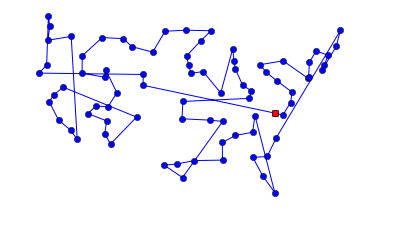

80 city tour with length 17972.8 in 0.008 secs for mst_tsp


In [118]:
plot_tsp(mst_tsp, USA_map)

Not so great.  Can the alteration strategy help?

In [119]:
def altered_mst_tsp(cities): return alter_tour(mst_tsp(cities))

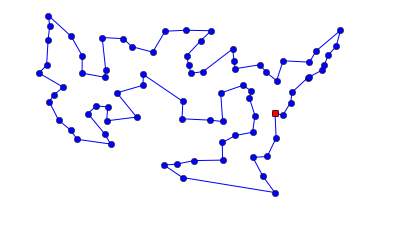

80 city tour with length 13779.8 in 0.054 secs for altered_mst_tsp


In [120]:
plot_tsp(altered_mst_tsp, USA_map)

Better. Let's go to the benchmarks:

In [121]:
benchmarks([mst_tsp, nn_tsp, greedy_tsp, dq_tsp])

                  mst_tsp | 5952.8 ± 394 ( 5097 to  6721) |  0.004 secs/map | 30 ⨉ 60-city maps
                   nn_tsp | 5689.8 ± 487 ( 4536 to  6861) |  0.001 secs/map | 30 ⨉ 60-city maps
               greedy_tsp | 5312.9 ± 462 ( 4404 to  6262) |  0.003 secs/map | 30 ⨉ 60-city maps
                   dq_tsp | 5202.4 ± 251 ( 4479 to  5574) |  0.067 secs/map | 30 ⨉ 60-city maps


Not very encouraging: `mst_tsp` is the second slowest and has the longest tours.  I'm sure I could make it faster (at the cost of making the code a bit more complicated), but there is no point if the tours are going to be longer.  

What happens when we add the alteration strategy?

In [122]:
benchmarks([altered_dq_tsp, altered_nn_tsp, altered_mst_tsp, altered_greedy_tsp, repeated_altered_nn_tsp])

           altered_dq_tsp | 4879.8 ± 290 ( 4180 to  5409) |  0.077 secs/map | 30 ⨉ 60-city maps
           altered_nn_tsp | 4812.1 ± 263 ( 4091 to  5320) |  0.012 secs/map | 30 ⨉ 60-city maps
          altered_mst_tsp | 4793.8 ± 310 ( 4135 to  5433) |  0.017 secs/map | 30 ⨉ 60-city maps
       altered_greedy_tsp | 4780.0 ± 297 ( 3934 to  5383) |  0.013 secs/map | 30 ⨉ 60-city maps
  repeated_altered_nn_tsp | 4628.8 ± 233 ( 3925 to  5120) |  0.238 secs/map | 30 ⨉ 60-city maps


Now `altered_mst_tsp` is in the middle of the pack, both in tour length and in run time.

So why would we want to use the rather complicated minimum spanning tree algorithm, when the greedy algorithm is  simpler to implement, runs faster, and produces shorter tours?

Guaranteed Tour Length!
---

The great thing about the minimum spanning tree algorithm is that it comes with a *guarantee*, which none of the other algorithms offer. You are guaranteed that the tour length it comes up with will be no worse than twice as long as the optimal tour.  (And, with a bit more complication, you can modify it to give a guarantee of 1.5 times longer.)  The guarantee works like this:

1. The minimum spanning tree, by definition, connects all the tours with the shortest possible total length.
2. So if you could follow each edge in the spanning tree just once, and that formed a legal tour, then that would be guaranteed to be
a minimal tour.  
3. But you can't do that in general; in general there will be places where you skip tp the next city without following the spanning tree.  Any such skip, however, is a straight line, and thus will be less than you would take if you went to the next city by following along the spanning tree.
4. If you did follow along the spanning tree, you would follow some edges twice, and some edges once.  hence the total length of the tour would be at most twice the spanning tree, and thus as most twice the minimal tour.

A guarantee is great from a theoretical point of view, but in practice the greedy or nearest neighbor algorithms do just as well or better than the minimum spanning tree, on the maps that we actually see. 

>>> Shoulders of Giants: Held-Karp Algorithm (`hk_tsp`)
===

<a href="http://www.computerhistory.org/collections/catalog/102650390"><img src="http://archive.computerhistory.org/resources/still-image/IBM/IBM_People/IBM.3_mathematicians_Held_Shareshian_Karp.ca1964.102650390.lg.jpg">
<br>Held, Shareshian, Karp (Computer History Museum)</a>

<a href="http://xkcd.com/399/">
<img src="http://imgs.xkcd.com/comics/travelling_salesman_problem.png">
<br>xkcd 399
</a>

Another algorithm that shows up with a literature search is the [Held-Karp Dynamic Programming Algorithm](http://en.wikipedia.org/wiki/Held%E2%80%93Karp_algorithm), named after giants [Michael Held](http://www.computerhistory.org/collections/catalog/102650390) and [Richard Karp](http://en.wikipedia.org/wiki/Richard_M._Karp). It is an algorithm for finding optimal tours, not approximate ones, so it is not appropriate for large *n*.  But even in its simplest form, without any programming tricks, it can go quite a bit further than `alltours_tsp`.  That is because `alltours_tsp` was O(*n*!), while the Held-Karp algorithm is only O(*n*<sup>2</sup> 2<sup>*n*</sup>).  

How did Held and Karp achieve this speedup?  They noticed that `alltours_tsp` wastes a lot of time with permutations that can't possibly be optimal tours.  Consider the following 10-city problem, with a 6-city segment shown:

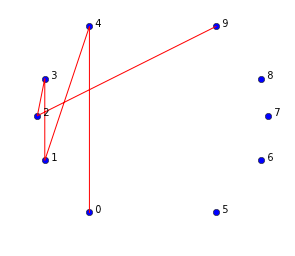

In [123]:
plot_labeled_lines(cross, 'r-', [0, 4, 1, 3, 2, 9])

The `alltours_tsp` would generate 4! different tours that start with those 6 cities, and continue with all permutations of the other 4 cities. But that seems wasteful: there is no way that this segment could be part of an optimal tour, so why waste time on it?  Now to make that claim, we have to prove that this segment can never be part of an optimal tour.  That proof comes down to two things.  First, we demonstrate another tour that also starts in city 0 and ends in city 9, and along the way goes through cities 1 through 4, and is shorter:

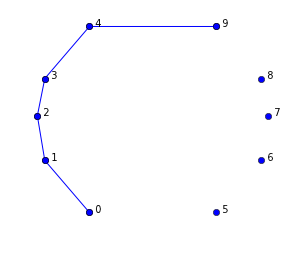

In [124]:
plot_labeled_lines(cross, [0, 1, 2, 3, 4, 9])

Second, we need this key property:

>*Given a start city A, an end city C, and a set of middle cities Bs, then out of all the segments that start in A, end in C, and go through all and only the cities in Bs, only the shortest segment could ever be part of the optimal tour. 

Of course, we don't know that the optimal tour goes through exactlt those Bs cities before hitting C.  But if it does, then we need only consider the permutation of Bs that leads to the shortest segment.  So we can throw out the red zig-zag segment above, and keep the nice smooth blue segment.

So far we have only been talking about segments.  We know that the TSP is defined for tours, not segments. So even if we find the shortest possible segment, it might not be the shortest possible tour.  But here's something we do know: a tour has to end somewhere.  So just find the shortest segment from the start city, `A`, to every possible end city, `C`.  That will give you *n*-2 segments. Out of those, don't choose the shortest *segment*, but rather choose the shortest *tour*.

That gives us our algorithm:

In [125]:
def hk_tsp(cities):
    """The shortest tour of this set of cities, using the Held-Karp approach.
    For each end city C, find the shortest segment from A (the start) to C.
    Out of all these shortest segments, pick the one that is the shortest tour."""
    A = first(cities)
    segments = [shortest_segment(A, cities - {A, C}, C)
                for C in cities if C is not A]
    return shortest_tour(segments)

# TO DO: function: shortest_segment(A, Bs, C)

Now for `shortest_segment(A, Bs, C)`.  It is defined to produce the shortest segment that starts in city `A`, ends in `C`, and visits some permutation of `Bs` cities in the middle.  If there are no `Bs` cities, then of course the shortest segment is to go directly from `A` to `C`.  If there are `Bs` cities, then one of them has to be the last `B` city visited (just before visiting `C`). So for each `B`, find the shortest segment that first goes from `A`, through all the other `Bs` cities, then to `B`, and finally to `C`.  Out of all these candidate segments, return the one with the minimum segment length.

**Note:** the decorator `@memoize` makes this a **dynamic programming** algorithm, which is a fancy name meaning that we cache the results of sub-computations because we will re-use them multiple times.

In [126]:
@memoize
def shortest_segment(A, Bs, C):
    "The shortest segment starting at A, going through all Bs, and ending at C."
    if not Bs:
        return [A, C]
    else:
        segments = [shortest_segment(A, Bs - {B}, B) + [C] 
                    for B in Bs]
        return min(segments, key=segment_length)
            
def segment_length(segment):
    "The total of distances between each pair of consecutive cities in the segment."
    # Same as tour_length, but without distance(tour[0], tour[-1])
    return sum(distance(segment[i], segment[i-1]) 
               for i in range(1, len(segment)))

That's all there is to it.  Let's compare `alltours_tsp` with `hk_tsp` on 10 city tours:

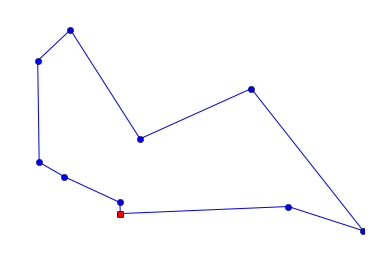

10 city tour with length 2492.2 in 2.595 secs for alltours_tsp


In [127]:
plot_tsp(alltours_tsp, Cities(10))

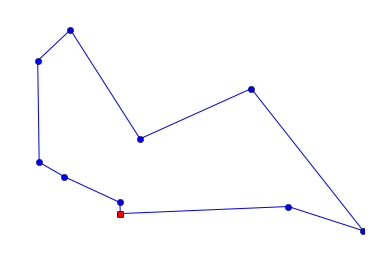

10 city tour with length 2492.2 in 0.096 secs for hk_tsp


In [128]:
plot_tsp(hk_tsp, Cities(10))

We see that `hk_tsp` returns the optimal tour, and it is a lot faster.  We can take `hk_tsp` into uncharted territory well beyond the reach of  `alltours_tsp`:

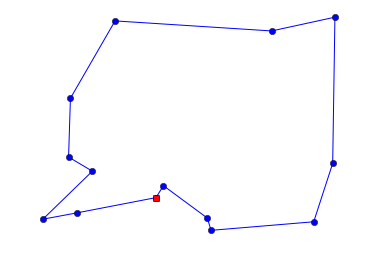

14 city tour with length 2617.2 in 2.492 secs for hk_tsp


In [129]:
plot_tsp(hk_tsp, Cities(14))

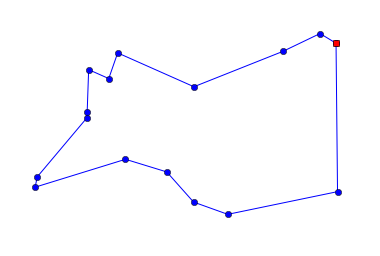

16 city tour with length 2416.8 in 14.761 secs for hk_tsp


In [130]:
plot_tsp(hk_tsp, Cities(16))

Not bad! In 11 seconds, we did what `alltours_tsp` would have taken an estimated 200 days to complete! Let's repeat the table of expected times, comparing the All Tours algorithm with the Held-Karp algorithm:

<table>
<tr><th>n <th>`alltours_tsp(Cities(n))`<th>`hk_tsp(Cities(n))`
<tr><td>  <td>expected time &approx; O(n!)<td>expected time &approx; O(n<sup>2</sup> 2<sup>n</sup>)
<tr><td>10<td> 10! tours = 2 secs                <td>0.1 secs 
<tr><td>11<td>2 secs &times; 11! / 10! &approx; 22 secs  <td>0.2 secs
<tr><td>12<td>2 secs &times; 12! / 10! &approx; 4 mins   <td>0.4 secs
<tr><td>14<td>2 secs &times; 14! / 10! &approx; 13 hours <td>3 secs
<tr><td>16<td>2 secs &times; 16! / 10! &approx; 200 days <td> 16<sup>2</sup> 2<sup>16</sup> tours = 11 secs
<tr><td>18<td>2 secs &times; 18! / 10! &approx; 112 years
<td>11 secs &times; (18/16)<sup>2</sup> 2<sup>(18-16)</sup> &approx; 1 min
<tr><td>25<td>2 secs &times; 25! / 10! &approx; 270 billion years
<td> 11 secs &times; (25/16)<sup>2</sup> 2<sup>(25-16)</sup>  &approx; 4 hours
<tr><td>50<td>2 secs &times; 50! / 10! &approx; 5 &times; 10<sup>50</sup> years</a><td>11 secs &times;  (50/16)<sup>2</sup> 2<sup>(50-16)</sup> &approx; 58,000 years
</table>

So if we had some patience, we could find the optimal tour for a 25 city map, but we still can't handle the 50-city landmarks map.
(There are refinements to Held-Karp that can handle 50-city maps, and could do it even with 1960s-era computing power.)

We're starting to run out of tricks, but we have one more general strategy to consider.

>>> Ensembles of Other Algorithms (`ensemble_tsp`)
====

When we have several optimization algorithms and we're not sure which is best, we can always try them all and take the best result.  This increases the run time, but it means that we get to throw everything we have at the problem.  We will define `ensemble_tsp`, which calls upon the other algorithms we have developed.  First, if the set of inut cities is small enough, it solves the problem optimally with `hk_tsp`.  If the set is too large it tries all the best algorithms, and takes the best result:

In [131]:
ensemble = [altered_dq_tsp, altered_greedy_tsp, altered_mst_tsp, repeated_altered_nn_tsp]

def ensemble_tsp(cities, threshold=16, algorithms=ensemble): 
    "Apply all algorithms to cities and take the shortest resulting tour."
    if len(cities) <= threshold:
        return hk_tsp(cities)
    else:
        return shortest_tour(tsp(cities) for tsp in algorithms)

Let's go to the benchmarks:

In [132]:
benchmarks(ensemble + [ensemble_tsp])

           altered_dq_tsp | 4879.8 ± 290 ( 4180 to  5409) |  0.077 secs/map | 30 ⨉ 60-city maps
       altered_greedy_tsp | 4780.0 ± 297 ( 3934 to  5383) |  0.013 secs/map | 30 ⨉ 60-city maps
          altered_mst_tsp | 4793.8 ± 310 ( 4135 to  5433) |  0.017 secs/map | 30 ⨉ 60-city maps
  repeated_altered_nn_tsp | 4628.8 ± 233 ( 3925 to  5120) |  0.238 secs/map | 30 ⨉ 60-city maps
             ensemble_tsp | 4621.8 ± 232 ( 3925 to  5120) |  0.347 secs/map | 30 ⨉ 60-city maps


In [133]:
benchmarks(ensemble + [ensemble_tsp], Maps(30, 120))

           altered_dq_tsp | 6816.8 ± 291 ( 6232 to  7363) |  0.564 secs/map | 30 ⨉ 120-city maps
       altered_greedy_tsp | 6577.3 ± 223 ( 6184 to  7091) |  0.060 secs/map | 30 ⨉ 120-city maps
          altered_mst_tsp | 6683.2 ± 224 ( 6156 to  7052) |  0.069 secs/map | 30 ⨉ 120-city maps
  repeated_altered_nn_tsp | 6441.1 ± 215 ( 6000 to  6946) |  1.124 secs/map | 30 ⨉ 120-city maps
             ensemble_tsp | 6431.1 ± 217 ( 6000 to  6946) |  1.820 secs/map | 30 ⨉ 120-city maps


In [134]:
benchmarks(ensemble + [ensemble_tsp], Maps(10, 250))

           altered_dq_tsp | 9726.9 ± 172 ( 9495 to 10102) |  4.801 secs/map | 10 ⨉ 250-city maps
       altered_greedy_tsp | 9062.8 ± 157 ( 8767 to  9404) |  0.262 secs/map | 10 ⨉ 250-city maps
          altered_mst_tsp | 9360.4 ± 181 ( 9066 to  9658) |  0.317 secs/map | 10 ⨉ 250-city maps
  repeated_altered_nn_tsp | 9096.4 ± 115 ( 8927 to  9283) |  5.362 secs/map | 10 ⨉ 250-city maps
             ensemble_tsp | 9040.0 ± 129 ( 8767 to  9283) | 10.770 secs/map | 10 ⨉ 250-city maps


So the `ensemble_tsp` is best (we knew before even trying the benchmarks that it must be at least tied for best), but only improves on `repeated_altered_nn_tsp` by less than 0.2%.

In [135]:
benchmarks(ensemble + [ensemble_tsp], (USA_map,))

           altered_dq_tsp |14209.6 ±   0 (14210 to 14210) |  0.176 secs/map | 1 ⨉ 80-city maps
       altered_greedy_tsp |14220.1 ±   0 (14220 to 14220) |  0.029 secs/map | 1 ⨉ 80-city maps
          altered_mst_tsp |13779.8 ±   0 (13780 to 13780) |  0.054 secs/map | 1 ⨉ 80-city maps
  repeated_altered_nn_tsp |13633.0 ±   0 (13633 to 13633) |  0.454 secs/map | 1 ⨉ 80-city maps
             ensemble_tsp |13633.0 ±   0 (13633 to 13633) |  0.716 secs/map | 1 ⨉ 80-city maps


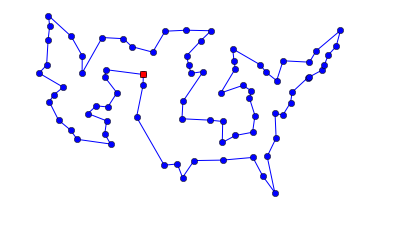

80 city tour with length 13491.1 in 1.880 secs for <lambda>


In [136]:
plot_tsp(lambda cities: repeated_altered_nn_tsp(cities, 80), USA_map)

In [137]:
benchmarks([altered_greedy_tsp, altered_mst_tsp, repeated_altered_nn_tsp], (USA_big_map,))

       altered_greedy_tsp |43716.7 ±   0 (43717 to 43717) |  7.398 secs/map | 1 ⨉ 1089-city maps
          altered_mst_tsp |45796.8 ±   0 (45797 to 45797) | 10.370 secs/map | 1 ⨉ 1089-city maps
  repeated_altered_nn_tsp |44387.7 ±   0 (44388 to 44388) |135.496 secs/map | 1 ⨉ 1089-city maps


In [138]:
benchmarks([altered_greedy_tsp, altered_mst_tsp, repeated_altered_nn_tsp], (USA_landmarks_map,))

       altered_greedy_tsp |10512.1 ±   0 (10512 to 10512) |  0.012 secs/map | 1 ⨉ 50-city maps
          altered_mst_tsp |10451.1 ±   0 (10451 to 10451) |  0.022 secs/map | 1 ⨉ 50-city maps
  repeated_altered_nn_tsp |10235.3 ±   0 (10235 to 10235) |  0.209 secs/map | 1 ⨉ 50-city maps


Further Explorations
===

That's all I'm going to write for now.  But there are still plenty of open questions for you to explore:

* Branch and Cut: this is a technique to cut off a search early, when a partial solution is obviously not optimal.  We saw how Held-Karp cuts off some permutations of cities when another permutation is better.  A refinement on that is to keep track of, say, the best total length of the segment going through all the Bs cities.  Then, any time you have a partial segment through some of the Bs cities that exceeds the best total, we can stop right there, before even finishing all the Bs.  With this technique, you can find optimal tours for around 50 cities.
* Linear programming: Lookup the topic "linear programming" and see how it applies to TSP.
* Heuristic Algorithms: There are many approaches for using heurisitic estimates to find good (but not optimal) tours.  For example, "ant colony optimization algorithms" make random choices of which edge to follow, and then the edges that occur in the best tours get reinforced with some virtual pheromones, and other ants tend to follow those pheromones.
* `altered` as a function: we defined a lot of one-line functions that just called another algorithm, and then calles `alter_tour` on the result.  Can you write a function, `altered(func)`, which takes a TSP algorithm as argument, and returns a TSP algorithm that does the original algorithm and hen calls `alter_tour`?
* Why does `mst` produce an optimal result, while `greedy_tsp` does not, even though the two algorithms have similar structure in the way they iterate over `shortest_edges_first`?
* The code in this notebook was designed for clarity, not efficiency.  Can you make the code faster?
* What else are you interested in?